In [1]:
import os
import sys
import exp
import copy
from multiprocessing import Process, freeze_support
from threading import Thread
from time import sleep

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import copy
import re

from grid_manager import MPC_op
from data_loader import UCSD_dataloader
from battery_model import Battery_base
from optimizer import Battery_optimizer
from predictor import *
from exp_manager import ExperimentManager
from threading import Thread
from time import sleep,ctime

src_path = sys.path[0].replace("exp_notebook", "src")
#replace notebook as scripts
data_path = sys.path[0].replace("exp_notebook", "data")
if src_path not in sys.path:
    sys.path.append(src_path)
out_path = sys.path[0].replace("exp_notebook", "output")
log_folder=r'L:\Coding_project\Energy_grid_new_exp_local'
#log_folder=r'D:\Codes\Energy_grid_new_exp_local'


#L:\Coding_project\Energy_grid_new\output\experiments\thesis_track_p_grid\6h-bat-Oct-track-p-grid-2.xlsx
exp_suffix = "simple_debug"
exp_folder = os.path.join(out_path, "experiments", exp_suffix)
debug_folder = os.path.join(out_path, "debug_test")
assert os.path.exists(exp_folder)

save_path = os.path.join(log_folder,exp_suffix, "debug")
if not os.path.exists(save_path):
    os.makedirs(save_path)
assert os.path.exists(save_path)



In [2]:
bat_params_sample ={
    "bat_capacity": None,
    "bat_p_max": 3, # i.e., capacity (kWh) / p_bat_max (kW) = 3 (h)
    "bat_p_min": 3, # can omit, then p_bat_min = p_bat_max
    "bat_price": 150, # $/kWh (old: 1000, ref: Tesla Powerwall)
    "bat_efficacy": 0.98, 
    "bat_life_0": 3650, # days.
    "bat_cycle_0": 3000, # cycles in lifetime
    # battery degradation params
    "deg_model": "throughput",  
        # valid values: "throughput", "Crate", "rainflow", "DOD"
    #   [1. degradation ~ high C-rate]
    "deg_Crate_thres": (0.25, 0.25, 0.25, 0.25),
    "deg_Crate_lambda": (0.8, 1, 1.5, 2),
    #   [2. degradation ~ large cycle depth]
    "deg_rainflow_thres": (0.2, 0.2, 0.2, 0.4),
    "deg_rainflow_lambda": (0.6, 1, 1.5, 1.8),
    #   [3. degradation ~ low SoE range]
    "deg_DOD_thres": (0.5, 0.2, 0.2, 0.1),
    "deg_DOD_lambda": (1.3, 1.15, 0.85, 0.6),
}

op_params_sample = {"K": 96,
            "dc_price": 0.6,
            "ev_efficacy": 0.98,
            "energy_price_sell": 0.6, 
            "deg_model_opt": "unconscious",
            "ev_charge_rule": "flex",
            "ev_charge_rule_default": "alap",
            "p_grid_max": "1.5",}


In [3]:
params={}

op_params = copy.deepcopy(op_params_sample)
bat_params = copy.deepcopy(bat_params_sample)

bat_params["deg_model"] = params.get("deg_model", "DOD")
bat_params["bat_capacity"] = params.get("B_kWh", 350)
strategy = params.get("strategy", "optimal")

exe_K = params.get("exe_K",4)
op_params["deg_model_opt"] = params.get("deg_model_opt", "rainflow") 
op_params["ev_charge_rule"] = params.get("ev_charge_rule", "flex")
op_params["energy_price_sell"] = params.get("price_sell", "rainflow")
op_params["dc_price"] = params.get("price_dc", 0.6) 
p_grid_max = params.get("p_grid_max", "1.5") 
op_params["penalty_coef"]=params.get("penalty_coef", 0)
op_params["sol_save_steps"] = params.get("sol_save_steps",0)
op_params["dc_formulation"]=params.get("dc_formulation", "moving")

op_params["p_grid_max_method"]=params.get("p_grid_max_method","by_solution")
op_params["p_grid_max"] = None if p_grid_max is None else str(p_grid_max)
op_params["shift"]=params.get("shift",False)
op_params["shift_ratio"]=params.get("shift_ratio",0)
pred_model = params.get("pred_model", "Simple") 
print("pred_model:",pred_model)

Simple_dic={
    'bld':True,
    'pv':True,
    'ev':True
}
Simple_dic['bld']=params.get("simple_bld",True)
Simple_dic['pv']=params.get("simple_pv",True)
Simple_dic['ev']=params.get("simple_ev",True)

if pred_model=='GT':
    op_params["check_inconsistency"]=params.get("check_inconsistency",True)
else:
    op_params["check_inconsistency"]=False
pv_to_bld=params.get("pv_to_bld",0.5)
ev_to_bld=params.get("ev_to_bld",0.25)

# 2023/05/30 LunLong
# Trying to add bld pv ev into grid search parmas
bld=params.get("bld", "Hopkins")
pv=params.get("pv", "Hopkins")
ev=params.get("ev","OSLER")   

simple_bld_kws={
    'rule':params.get('simple_bld_rule','week'),
    'num':int(params.get('simple_bld_num',1)),
    'exp_alpha':params.get('simple_bld_exp_alpha',0.02),
}

simple_pv_kws={
    'rule':params.get('simple_pv_rule','day'),
    'num':int(params.get('simple_pv_num',4)),
    'exp_alpha':params.get('simple_pv_exp_alpha',0.2),
}

simple_ev_kws={
    'rule':params.get('simple_ev_rule','week'),
    'num':int(params.get('simple_ev_num',1)),
}
run_bat=params.get('run_bat_as_sol',True)
if run_bat in [False, "FALSE", "False", "false", 0]:
    run_bat_as_sol=False
elif run_bat in [True, "TRUE", "True", "true", 1]:
    run_bat_as_sol=True

if bld is None or pv is None or ev is None:
    raise Exception("Building related params are not prepoperly initiated")
'''
def convert_time(s):
    idx_hyphen = s.index("-")
    month, day = int(s[:idx_hyphen]), int(s[idx_hyphen+1:])
    return datetime(2019, month, day, 0, 0)
'''
def convert_time(s):
    numbers = re.findall(r'\d+',s)
    assert len(numbers)>=2 and len(numbers)<=4
    time = [10,1,0,0]
    for i in range(len(numbers)):
        time[i] = int(numbers[i]) 
    return datetime(2019, time[0], time[1], time[2], time[3])
t_start = convert_time("10-1-0-30")

t_start = convert_time(params.get("start", "5-1"))

t_end = convert_time(params.get("end", "5-8"))
'''
t_end=t_start+timedelta(hours=2)
#month_dic=[31,28,31,30,31,30,31,31,30,31,30,31]
month_dic=[2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2]
month=int(params.get("month_of_year",3))
op_params["K"]=96*month_dic[month-1]'''

print("K=",op_params["K"])

mpc = MPC_op()

# Step 1: load data
mpc.load_data(loader=UCSD_dataloader, 
    tstart_historical=datetime(2018,1,1,0,0),
    tstart_execution=datetime(2019,1,1,0,0),
    tend=datetime(2019,12,31,23,59), delta=0.25,
    bld=bld, pv=pv, ev=ev, pv_to_bld=pv_to_bld, ev_to_bld=ev_to_bld, Pmax=10,
    pred_model=pred_model)

'''
# Step 2: Load historical data
# ! add pred_model here
if pred_model=="GT":
    mpc.init_historical_data(loader=UCSD_dataloader,
        tstart=datetime(2019,1,1,0,0), tend=datetime(2019,12,31,23,59), delta=0.25,
        bld=bld, pv=pv, ev=ev, pv_to_bld=0.5, ev_to_bld=0.25, Pmax=10, pred_model=pred_model)
else:
    mpc.init_historical_data(loader=UCSD_dataloader,
        tstart=datetime(2018,11,30,0,0), tend=datetime(2019,12,31,23,59), delta=0.25,
        bld=bld, pv=pv, ev=ev, pv_to_bld=0.5, ev_to_bld=0.25, Pmax=10, pred_model=pred_model)
'''

# Step 3: specify other operational params
optimizer_params = {"strategy": strategy, "language":"gurobi"}

mpc.init_op_params(optimizer=Battery_optimizer, optimizer_params=optimizer_params, delta_0=0.25, **op_params)

# Step 4: specify battery
mpc.init_battery(model=Battery_base, params=bat_params, delta_0=0.5)

# Step 5: initialize predictor
# [Yi, 2023/03/08] modify predictor def

if pred_model=="Disturbance":
    distb_bld_kws={
        "rule":params.get("disturbance_rule", "uniform"),
        "loc":0,
        "scale":params.get("disturbance_scale", 0.03),
    }
    mpc.init_predictor(shortcut=pred_model, distb_bld_kws=distb_bld_kws,shift=op_params["shift"],delta=0.25,
                        simple_bld_kws=simple_bld_kws, simple_pv_kws=simple_pv_kws, simple_ev_kws=simple_ev_kws,
                        shift_ratio=op_params["shift_ratio"],Simple_dic=Simple_dic)
else:
    mpc.init_predictor(shortcut=pred_model, distb_bld_kws=None,shift=op_params["shift"],delta=0.25,
                        simple_bld_kws=simple_bld_kws, simple_pv_kws=simple_pv_kws, simple_ev_kws=simple_ev_kws,
                        shift_ratio=op_params["shift_ratio"],Simple_dic=Simple_dic)



pred_model: Simple
K= 96
None
!!!!!!!!!! MISSING VALUES !!!!!!!!!! || [bld] has [22] missing values
========== NA filled ==========
!!!!!!!!!! MISSING VALUES !!!!!!!!!! || [pv] has [16] missing values
========== NA filled ==========
!!!!!!!!!! EV SHORT DURATION !!!!!!!!!! || drop 0 sessions
{'rule': 'week', 'num': 1, 'exp_alpha': 0.02}
{'rule': 'day', 'num': 4, 'exp_alpha': 0.2}
exp_alpha for pv: 0.2
Notification of branch entry.


In [4]:
def get_gt_ev(ta,td):
    ev_sessions = mpc.data_pool.data.get("ev_sessions")
    sig = (ev_sessions["ta"] >= ta) & (ev_sessions["ta"] < td)
    to_concat = []
    to_concat.append(ev_sessions.loc[sig].copy())
    pred_before_sample = pd.concat(to_concat, axis=0)
    return pred_before_sample

def get_pred_ev(ta,td,freq_h=24):
    hours=(td-ta).total_seconds()/3600
    assert hours%freq_h==0
    rounds=int(hours/freq_h)
    pred_ev=[]
    t=ta
    for i in range(rounds):
        pred_ev.append(mpc.predictor.get_prediction(t,96,delta=0.25)['ev_sessions'])
        t=t+timedelta(hours=freq_h)
    pred_ev=pd.concat(pred_ev)
    
    return pred_ev

def convert_table(ta,td,EV,delta_h,e_targ_rule='average'):
    hours=(td-ta).total_seconds()/3600
    assert hours%delta_h==0
    rounds=int(hours/delta_h)
    EV_convert=pd.DataFrame(columns=['t_start','t_end','ev_I_onsite','total_e_targ','ave_e_targ'])
    ta_i=ta
    td_i=ta+timedelta(hours=delta_h)
    EV['e_req']=None
    if e_targ_rule=='average':
        EV['p_ave_req']=EV.apply(lambda x: x['e_targ']/((x['td']-x['ta']).total_seconds()/3600),axis=1)
    for i in range(rounds):
        EV_tmp=EV[(EV['ta']<=td_i)&(EV['td']>ta_i)].copy()
        EV_convert.loc[i,'t_start']=ta_i
        EV_convert.loc[i,'t_end']=td_i
        if len(EV_tmp)==0:
            EV_convert.loc[i,'ev_I_onsite']=0
            EV_convert.loc[i,'total_e_targ']=0
            EV_convert.loc[i,'ave_e_targ']=0
        else:
            EV_tmp['e_req']=EV_tmp.apply(lambda x: x['p_ave_req']*delta_h,axis=1)#(td_i-x['ta']).total_seconds()/3600,
            EV_convert.loc[i,'ev_I_onsite']=len(EV_tmp)
            EV_convert.loc[i,'total_e_targ']=EV_tmp['e_req'].sum()
            EV_convert.loc[i,'ave_e_targ']=EV_tmp['e_req'].sum()/len(EV_tmp)
        ta_i+=timedelta(hours=delta_h)
        td_i+=timedelta(hours=delta_h)
    return EV_convert


In [5]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import holidays
    
rc_={
    "figure.dpi":300,
    "font.size":10,
    "axes.facecolor":"white",
    "savefig.facecolor":"white",
    "text.usetex":False,
    "legend.frameon":False
}
plt.rcParams.update(rc_)

def plot_ev_gt_pred(pred,gt,ta=None,td=None,figsize=(20,5),y_limit_l=[-50,50],y_limit_r=[-15,15],
                    bar_key='total_e_targ',line_key='ev_I_onsite',bar_width=0.02,
                    major_interval=24,minor_interval=4,display_error=True,x_label=None,
                    display_non_work_day=True,display_ref_error=False,save_fn=None):
    fig, ax=plt.subplots(figsize=figsize)
    assert pred.loc[0,'t_end']-pred.loc[0,'t_start']==gt.loc[0,'t_end']-gt.loc[0,'t_start']
    pred=pred[ta:td].copy()
    gt=gt[ta:td].copy()
    assert len(pred)==len(gt)
    


    def check_date(date):
        # Check if the date is a holiday
        us_holidays = holidays.US()
        if date in us_holidays or date.weekday()>=5:
            return "holiday"
        if date-timedelta(days=1) in us_holidays:
            return "post_holiday"
        if date+timedelta(days=1) in us_holidays:
            return "pre_holiday"
        else:
            return "inter_work_day"
        '''
        if date.weekday()>=5:  
            return 2
        elif date in us_holidays:
            return 1
        else:
            return 0  '''
    
    interval=pred.loc[0,'t_end']-pred.loc[0,'t_start']
    ax.set_xlim(gt['t_start'].min(),gt['t_end'].max())
    ax.set_ylim(y_limit_l)
    total_error=0
    total_n_error=0
    max_abs_error=0
    n=0
    if display_error:
        
        ax.axhline(y=0,xmin=0,xmax=1,color='gray',linewidth=0.5)
        for i in range(len(gt)):
            if check_date(gt.loc[i,'t_start'])!=check_date(gt.loc[i,'t_start']-timedelta(days=7)) :
                color='purple'
                alpha=1
            else:
                color='darkorange'
                alpha=1
            '''    
            if check_date(gt.loc[i,'t_start']-timedelta(days=1)) in [1,2]:
                alpha=0
            if check_date(gt.loc[i,'t_start']+timedelta(days=1)) in [1,2]:
                alpha=0
            '''   
            ax.bar(x=np.array(gt.loc[i,'t_start']+interval/2),height=np.array(pred.loc[i,bar_key]-gt.loc[i,bar_key]), \
                bottom=np.zeros(1),color=color,width=bar_width,alpha=alpha,label='target_e')
            max_abs_error=max(abs(pred.loc[i,bar_key]-gt.loc[i,bar_key]),max_abs_error)
            total_error+=abs(pred.loc[i,bar_key]-gt.loc[i,bar_key])
            total_n_error+=abs(pred.loc[i,line_key]-gt.loc[i,line_key])
            n+=1
        ax.text(0.5,0.95,"mean_error_e="+str(round(total_error/n,ndigits=2)),ha='center',va='center',transform=ax.transAxes)
        ax.text(0.5,0.90,"mean_error_I="+str(round(total_n_error/n,ndigits=2)),ha='center',va='center',transform=ax.transAxes)
        ax.text(0.5,0.85,"max_abs_error="+str(round(max_abs_error,ndigits=2)),ha='center',va='center',transform=ax.transAxes)
        ax.set_ylabel("Total e req error (kWh)")
        ax2=ax.twinx()
        ax2.set_ylim(y_limit_r)
        ax2.plot(np.array(gt['t_start'])+interval/2,np.array(pred[line_key]-gt[line_key]),marker='.',markersize=2,linewidth=0,label='ev_I')
        ax2.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        ax2.set_ylabel("ev I error")
        

            
    else:
        '''ax.bar(x=np.array(pred['t_start'])-timedelta(hours=0.15),height=np.array(pred['total_e_targ']), \
            bottom=np.zeros(len(pred.index)),color='orange',width=0.02*(400/len(pred)),alpha=0.3)'''
        ax.bar(x=np.array(gt['t_start'])+timedelta(hours=0.15),height=np.array(gt['total_e_targ']), \
            bottom=np.zeros(len(pred.index)),color='green',width=bar_width,alpha=0.3)
        
    if display_non_work_day:
        for i in range(len(gt)):
            if check_date(gt.loc[i,'t_start'])=='holiday' : #and check_date(pred.loc[i,'t_end'])==1
                ax.axvspan(xmin=gt.loc[i,'t_start'],xmax=gt.loc[i,'t_end'],facecolor='dimgray', alpha=0.05)
            if check_date(gt.loc[i,'t_start'])==2 : #and check_date(pred.loc[i,'t_end'])==1
                ax.axvspan(xmin=gt.loc[i,'t_start'],xmax=gt.loc[i,'t_end'],facecolor='dimgray', alpha=0.05)
    if display_ref_error:
        for i in range(len(gt)):
            if check_date(gt.loc[i,'t_start'])!=check_date(gt.loc[i,'t_start']-timedelta(days=7)) : #and check_date(pred.loc[i,'t_end'])==1
                ax.axvspan(xmin=gt.loc[i,'t_start'],xmax=gt.loc[i,'t_end'],facecolor='red', alpha=0.2)
    
    date_format_major = mdates.DateFormatter('%d')
    date_format_minor = mdates.DateFormatter('%H')

    interval_major=mdates.HourLocator(interval=major_interval)
    ax.xaxis.set_major_locator(interval_major)
    interval_minor=mdates.HourLocator(interval=minor_interval)
    ax.xaxis.set_minor_locator(interval_minor)

    ax.xaxis.set_major_formatter(date_format_major)
    ax.xaxis.set_minor_formatter(date_format_minor)
    ax.set_xlabel("day of month"+'('+x_label+')')
    plt.tight_layout()
    
    if save_fn:
        plt.savefig(save_fn)
    
    return   total_error,total_n_error,max_abs_error,n
    #ax.legend(loc='upper left')

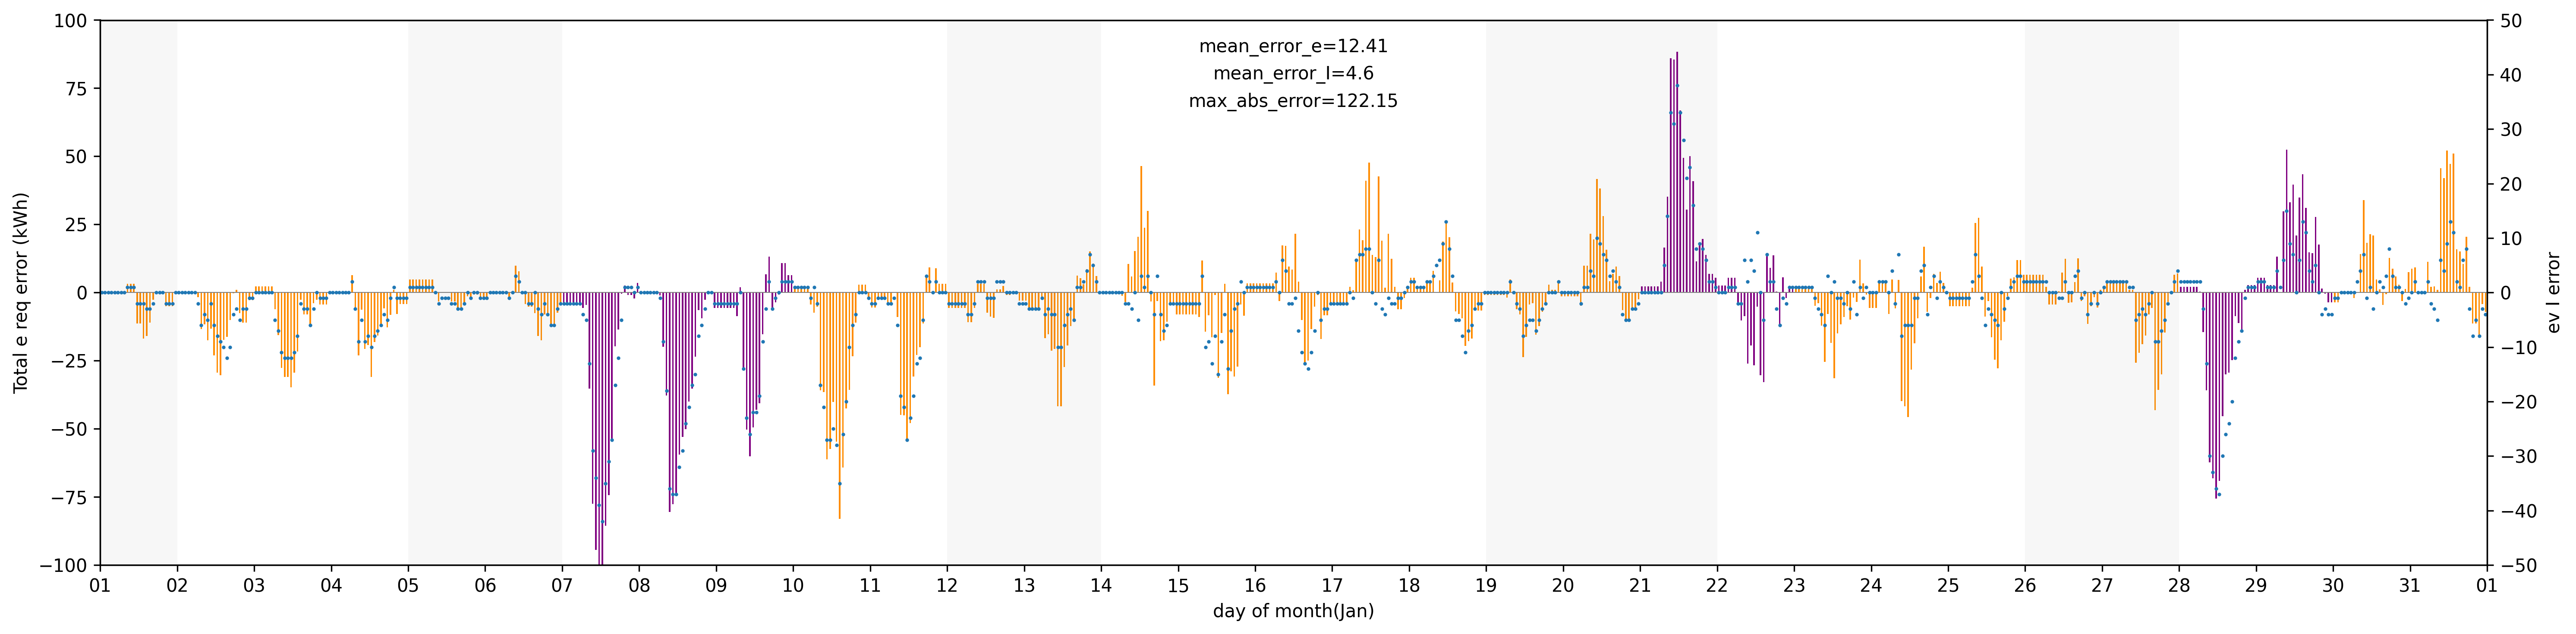

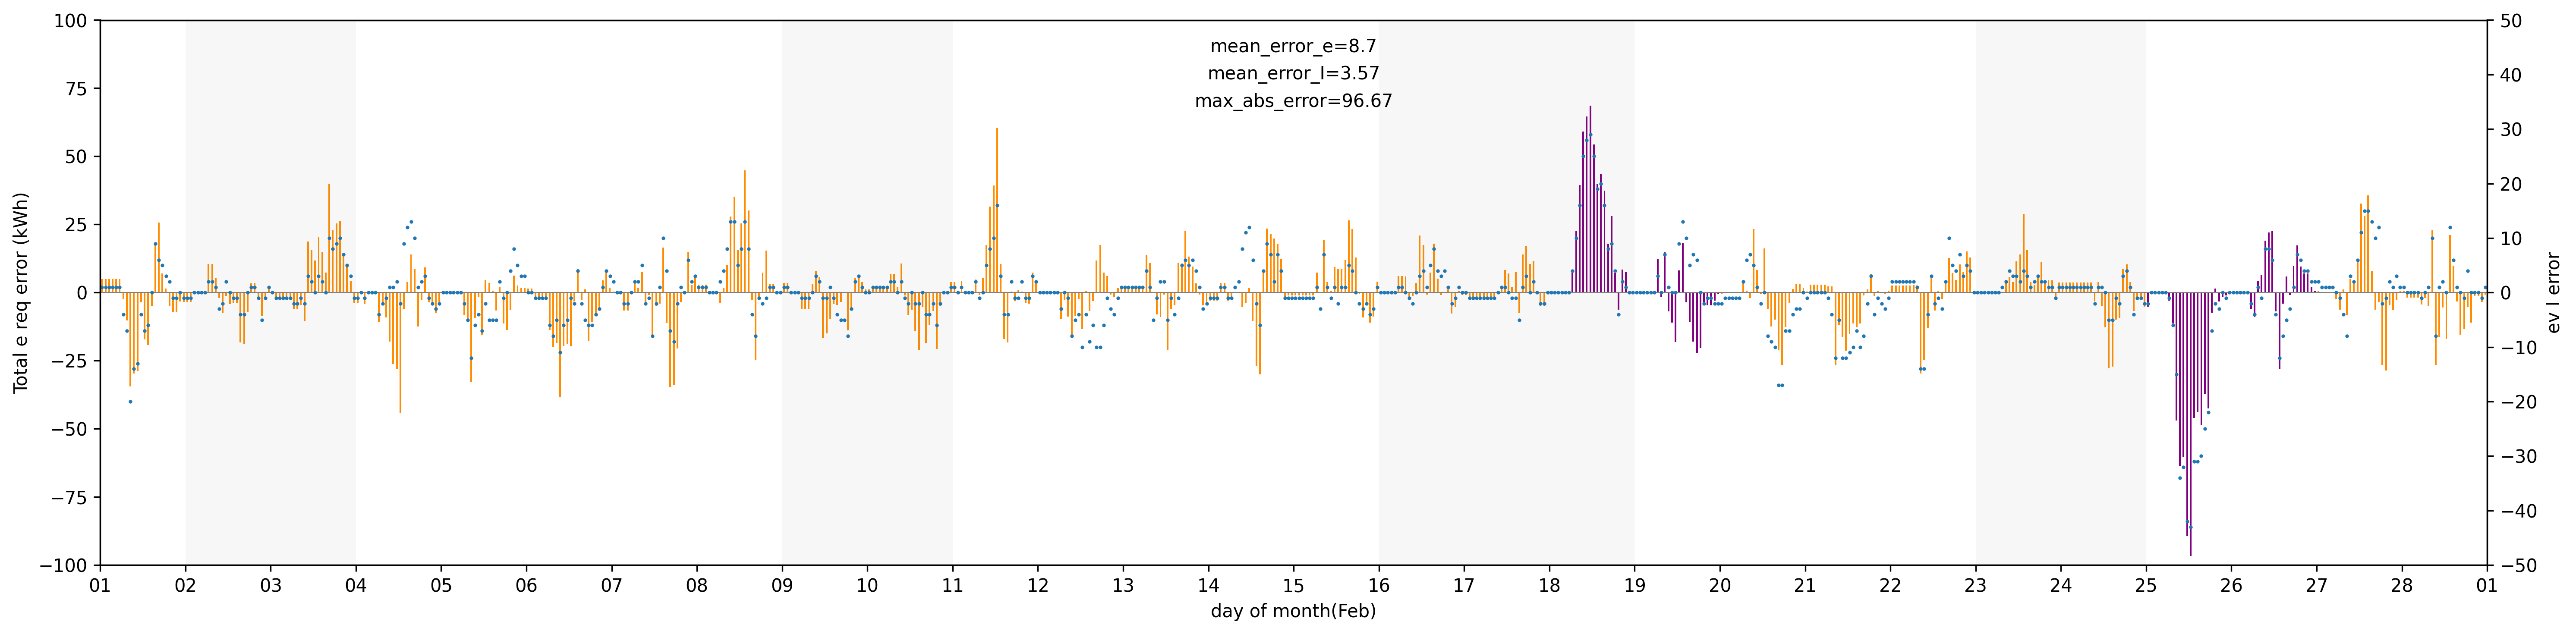

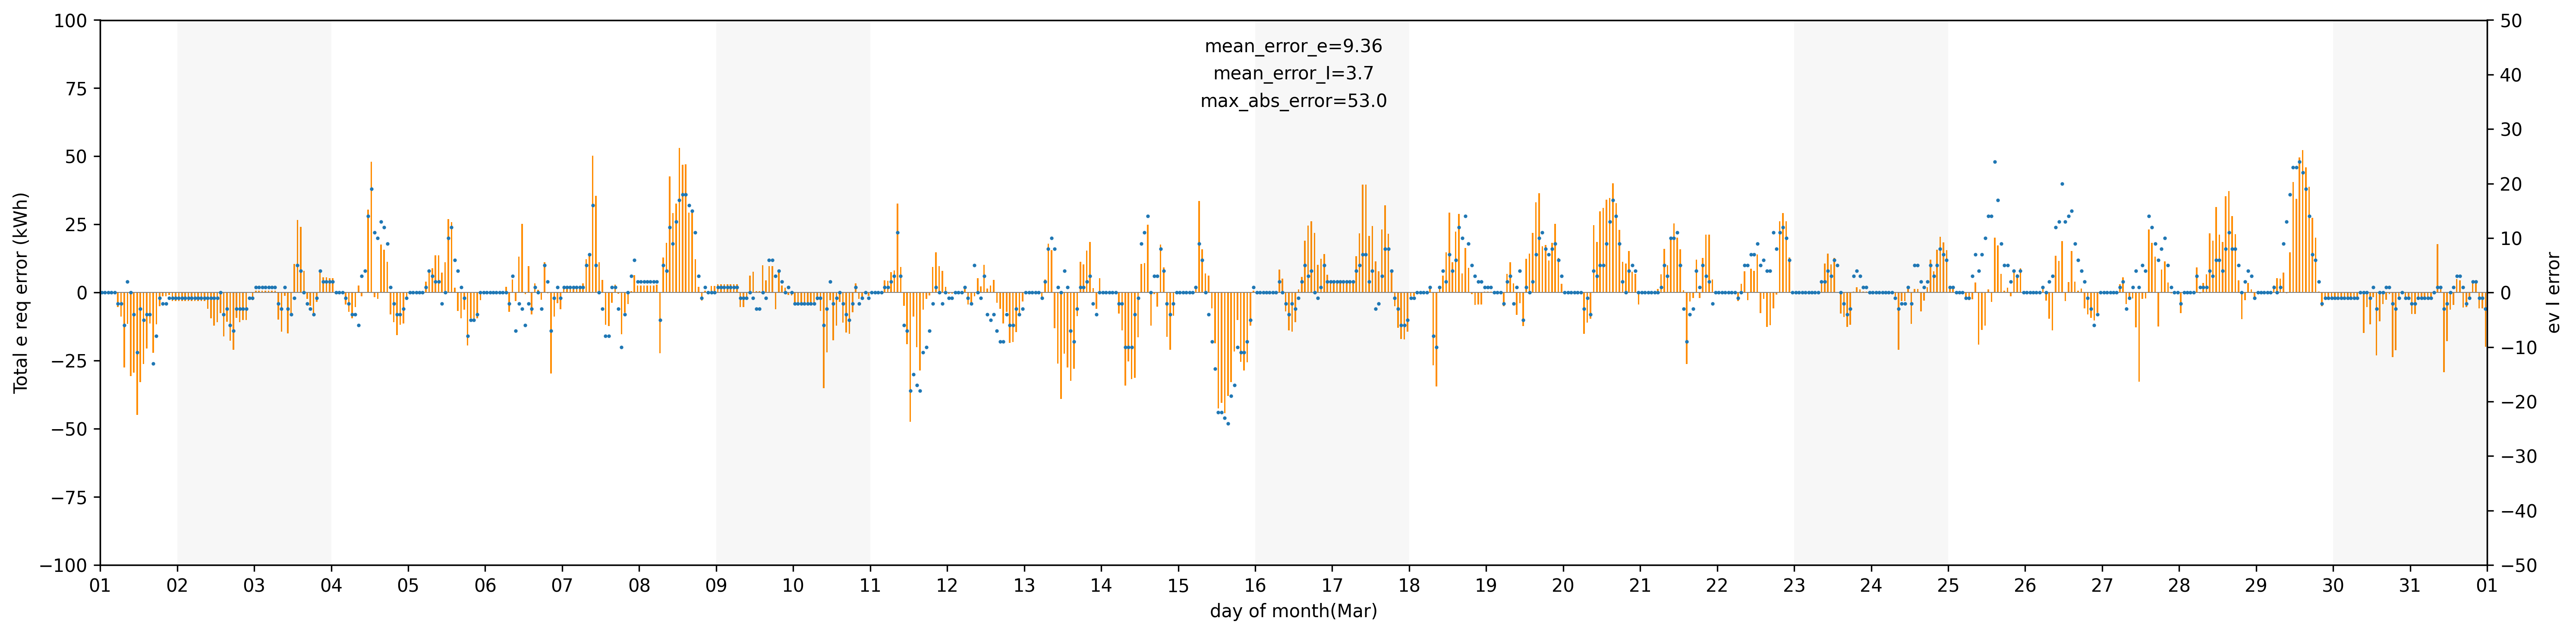

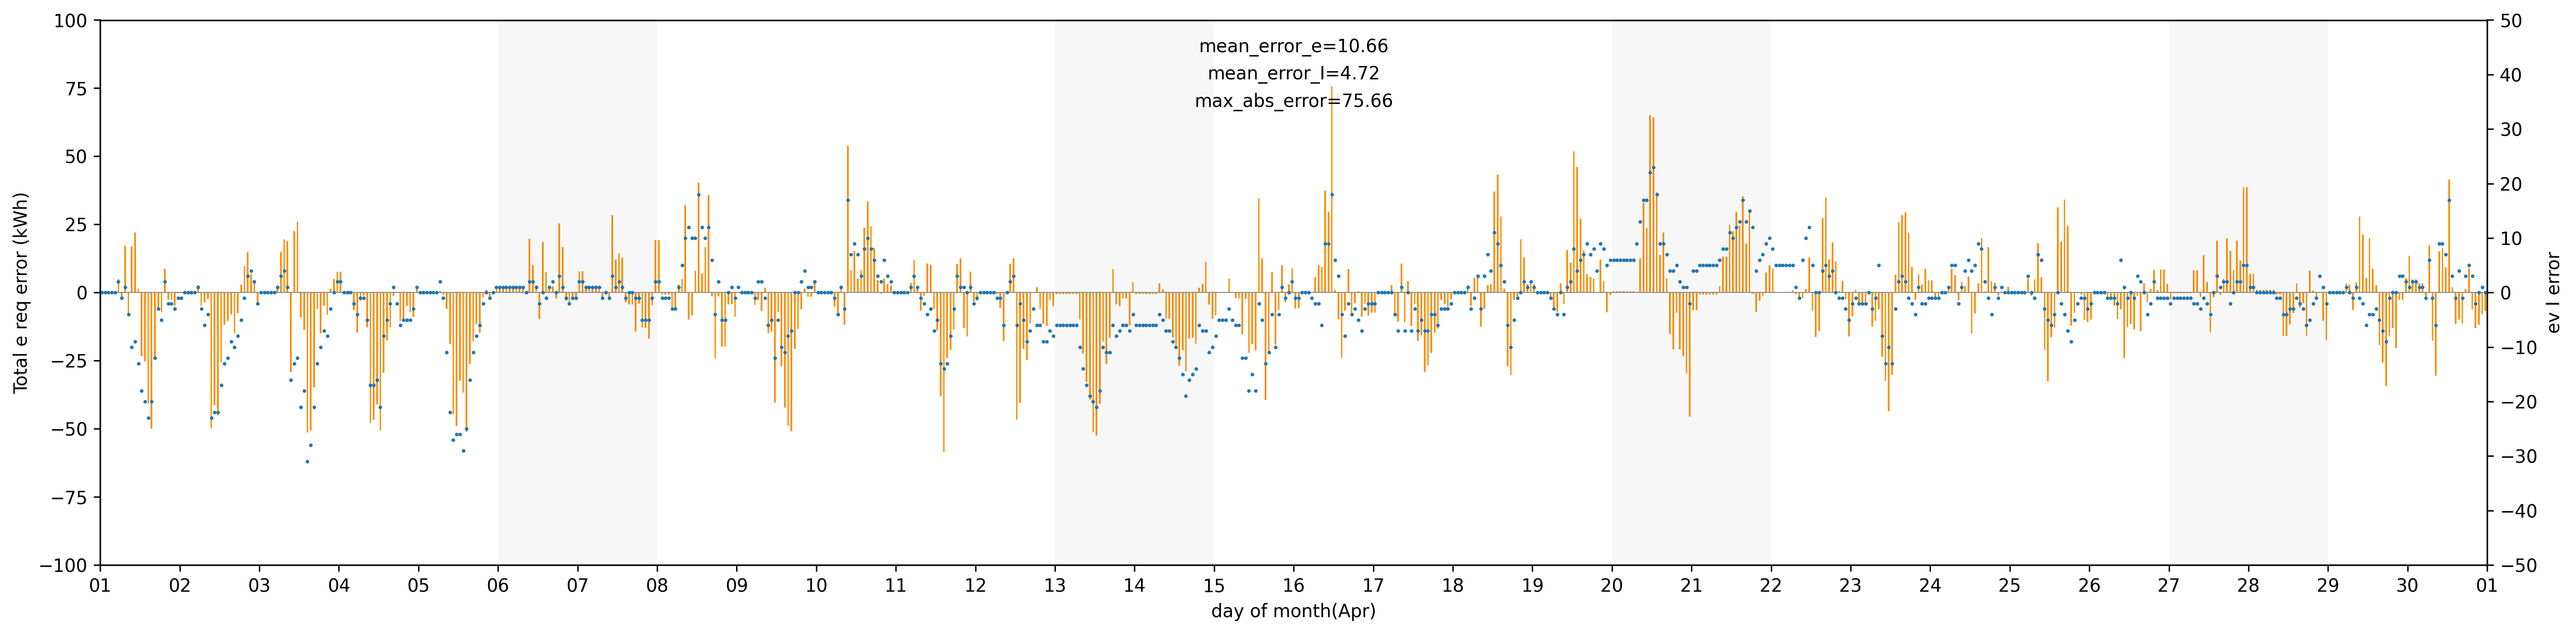

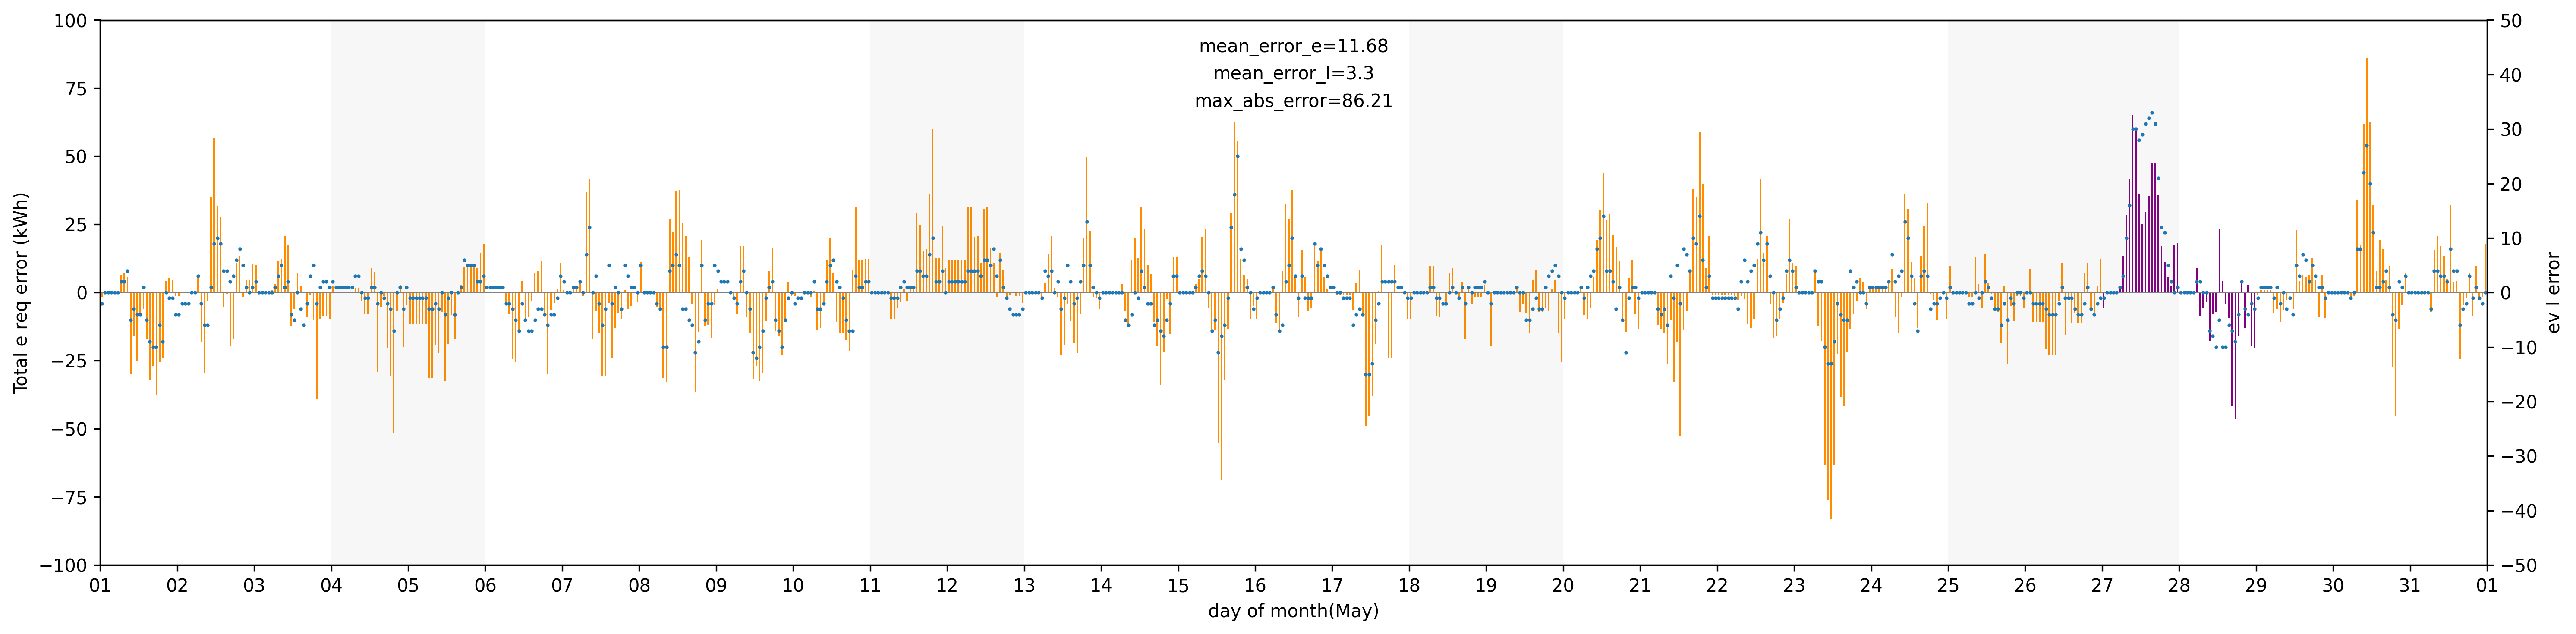

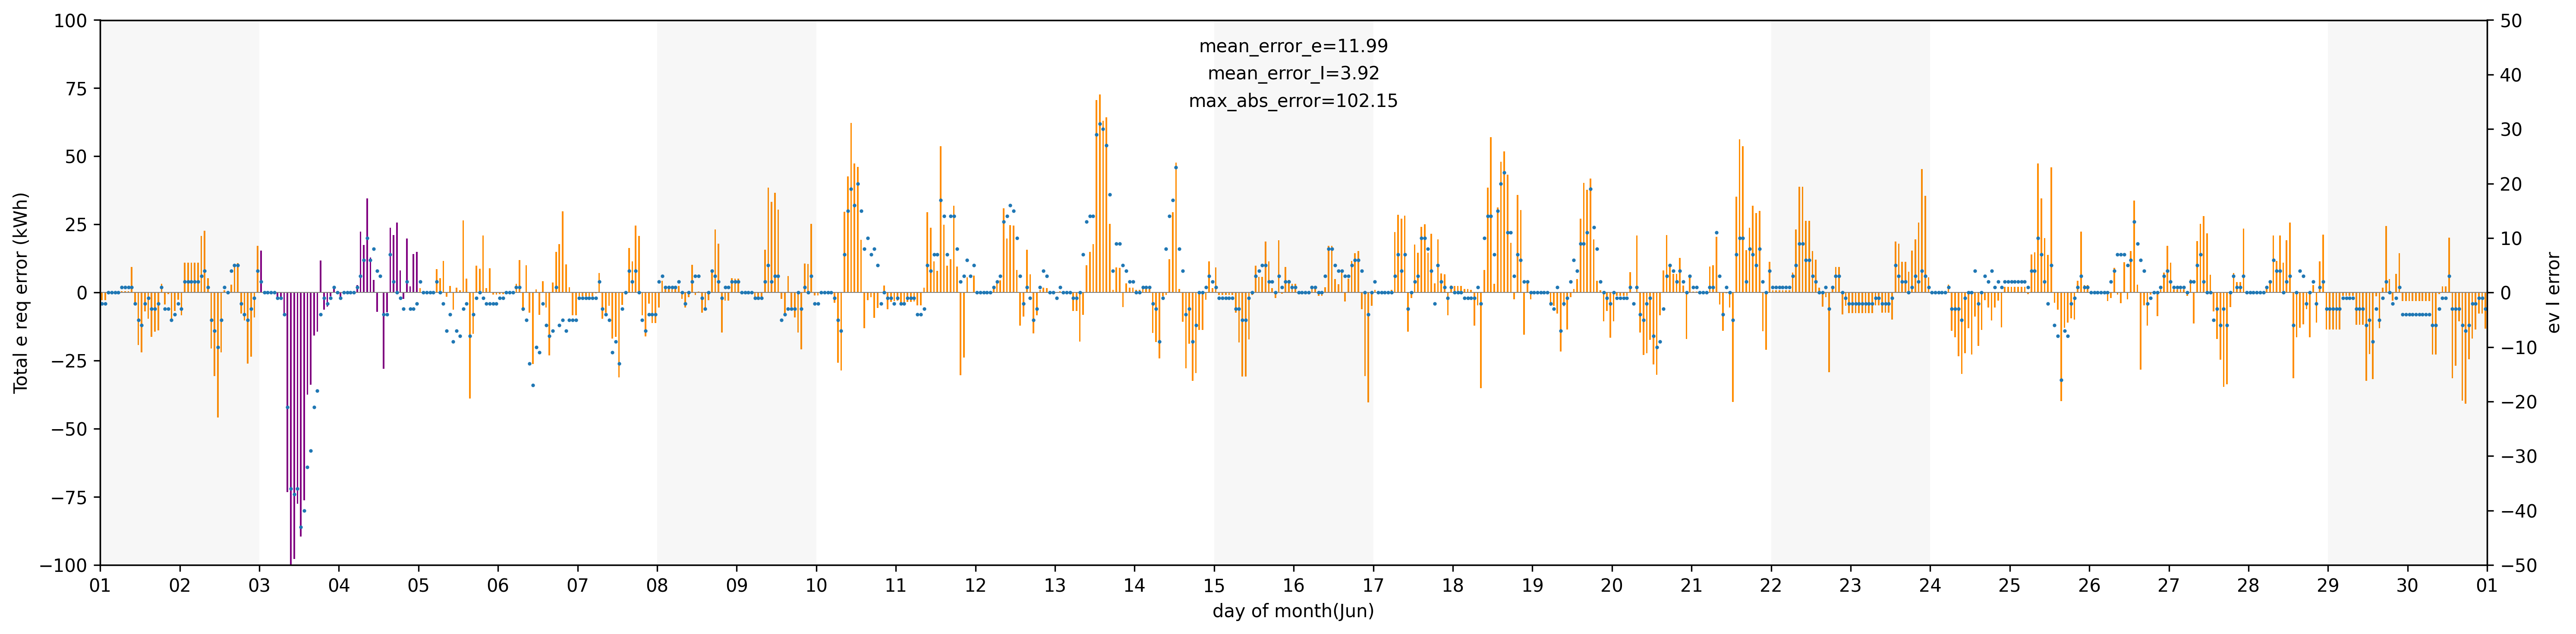

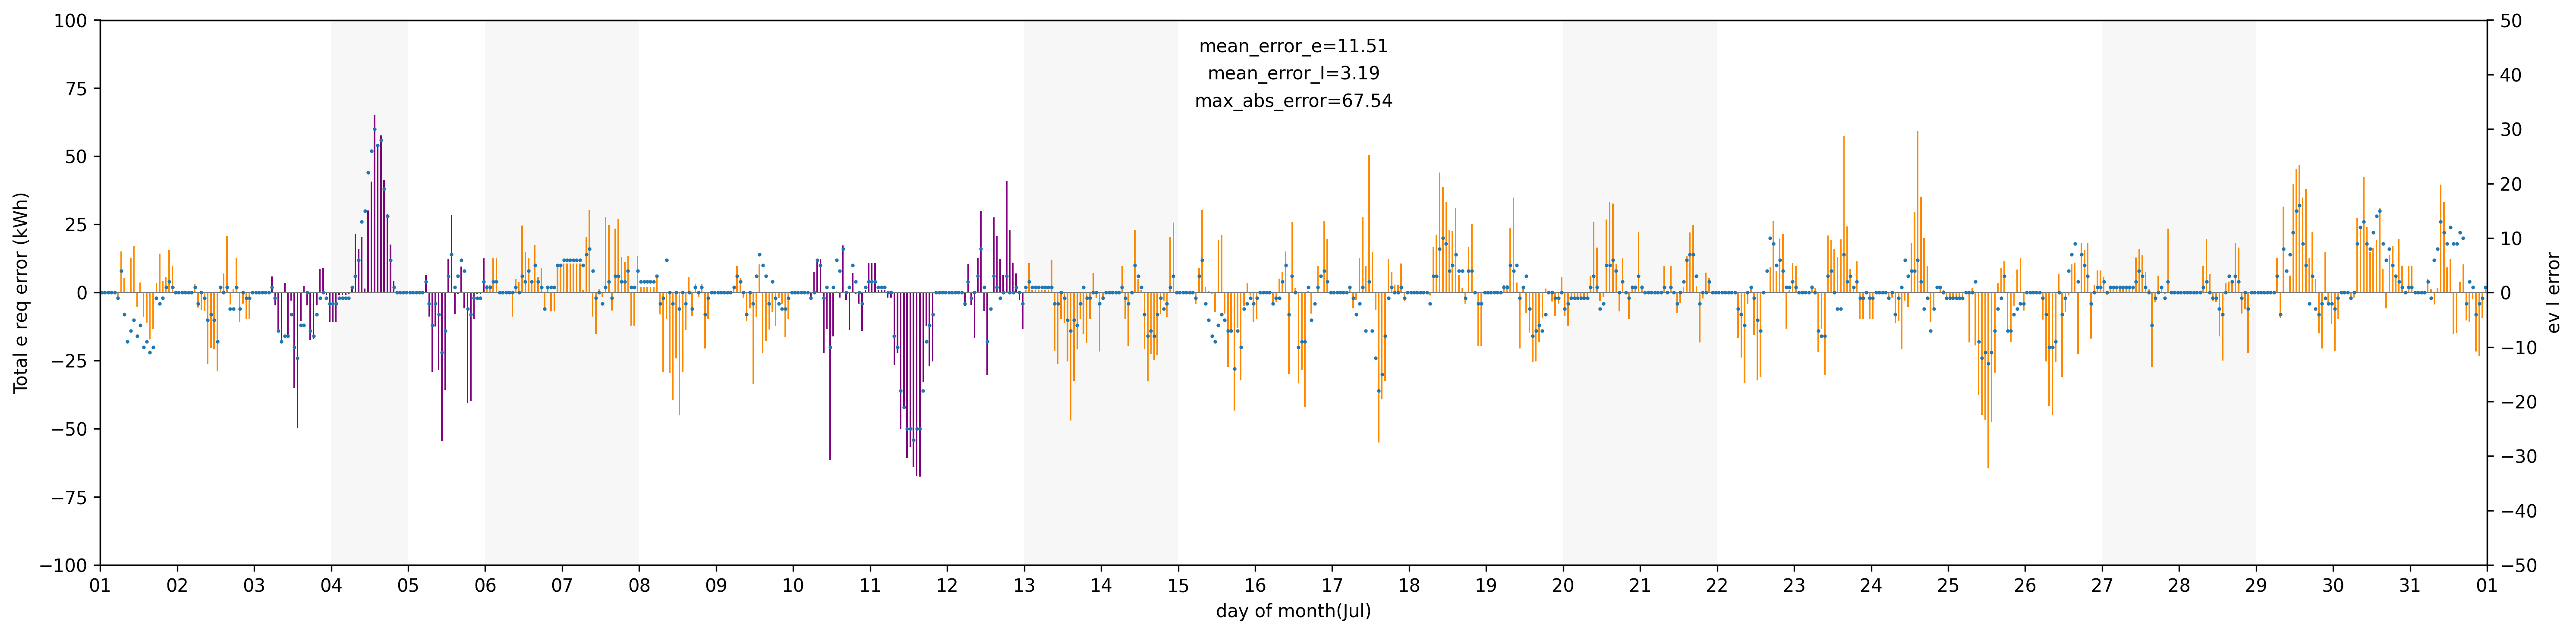

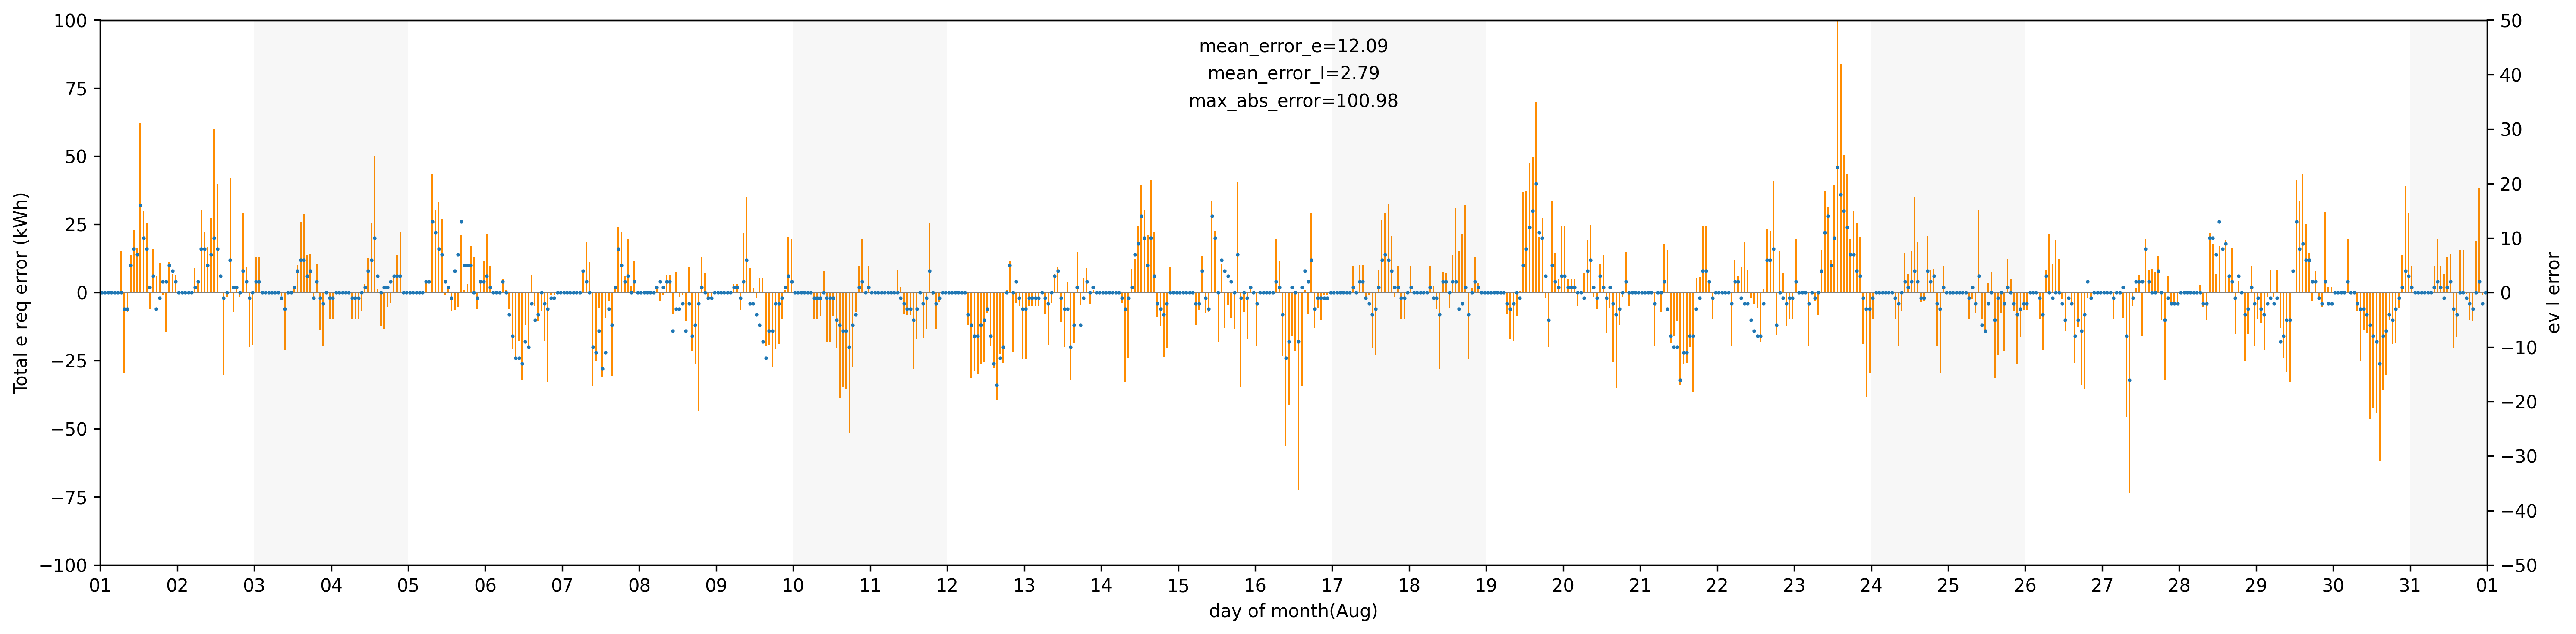

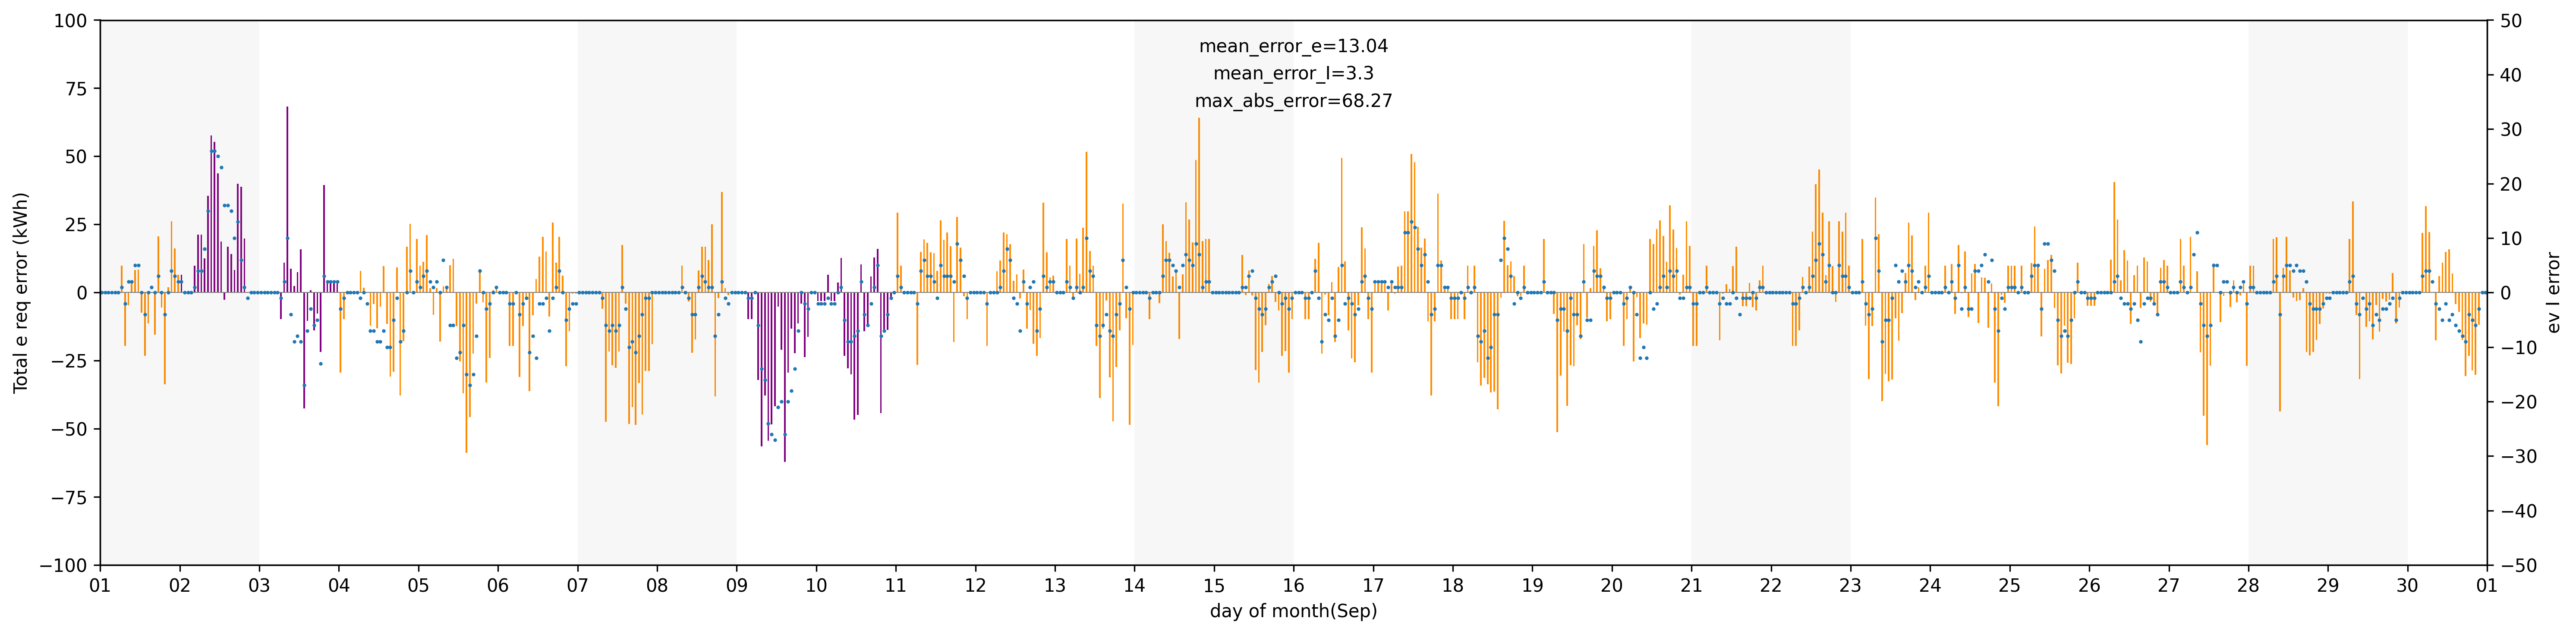

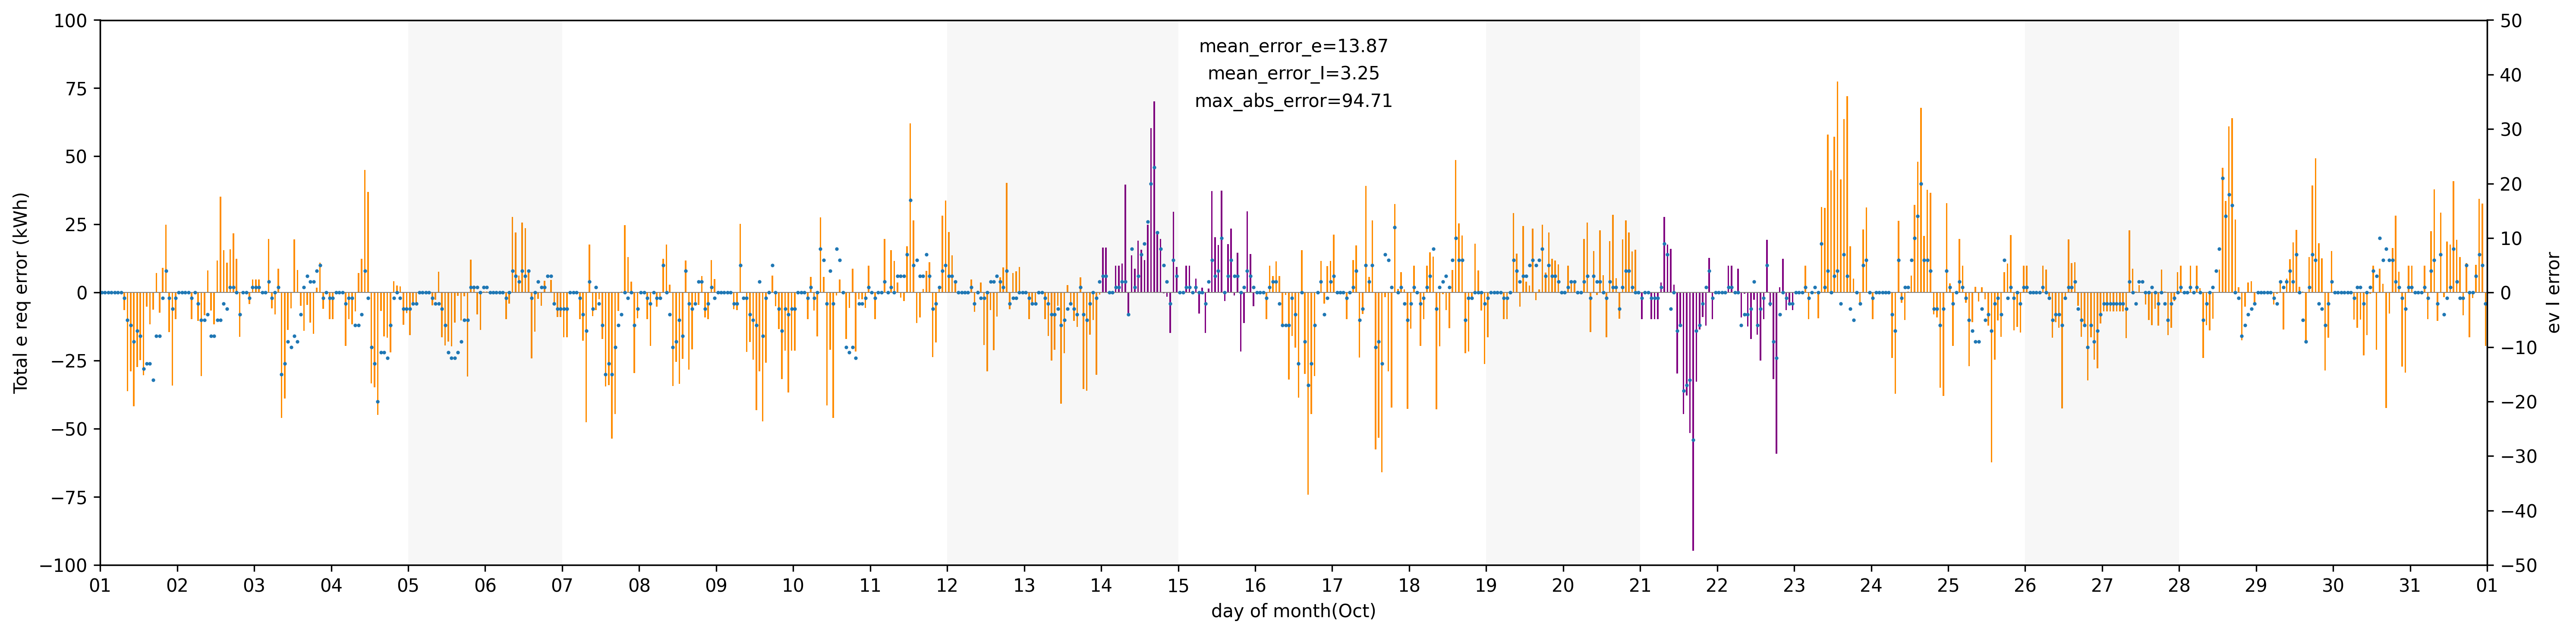

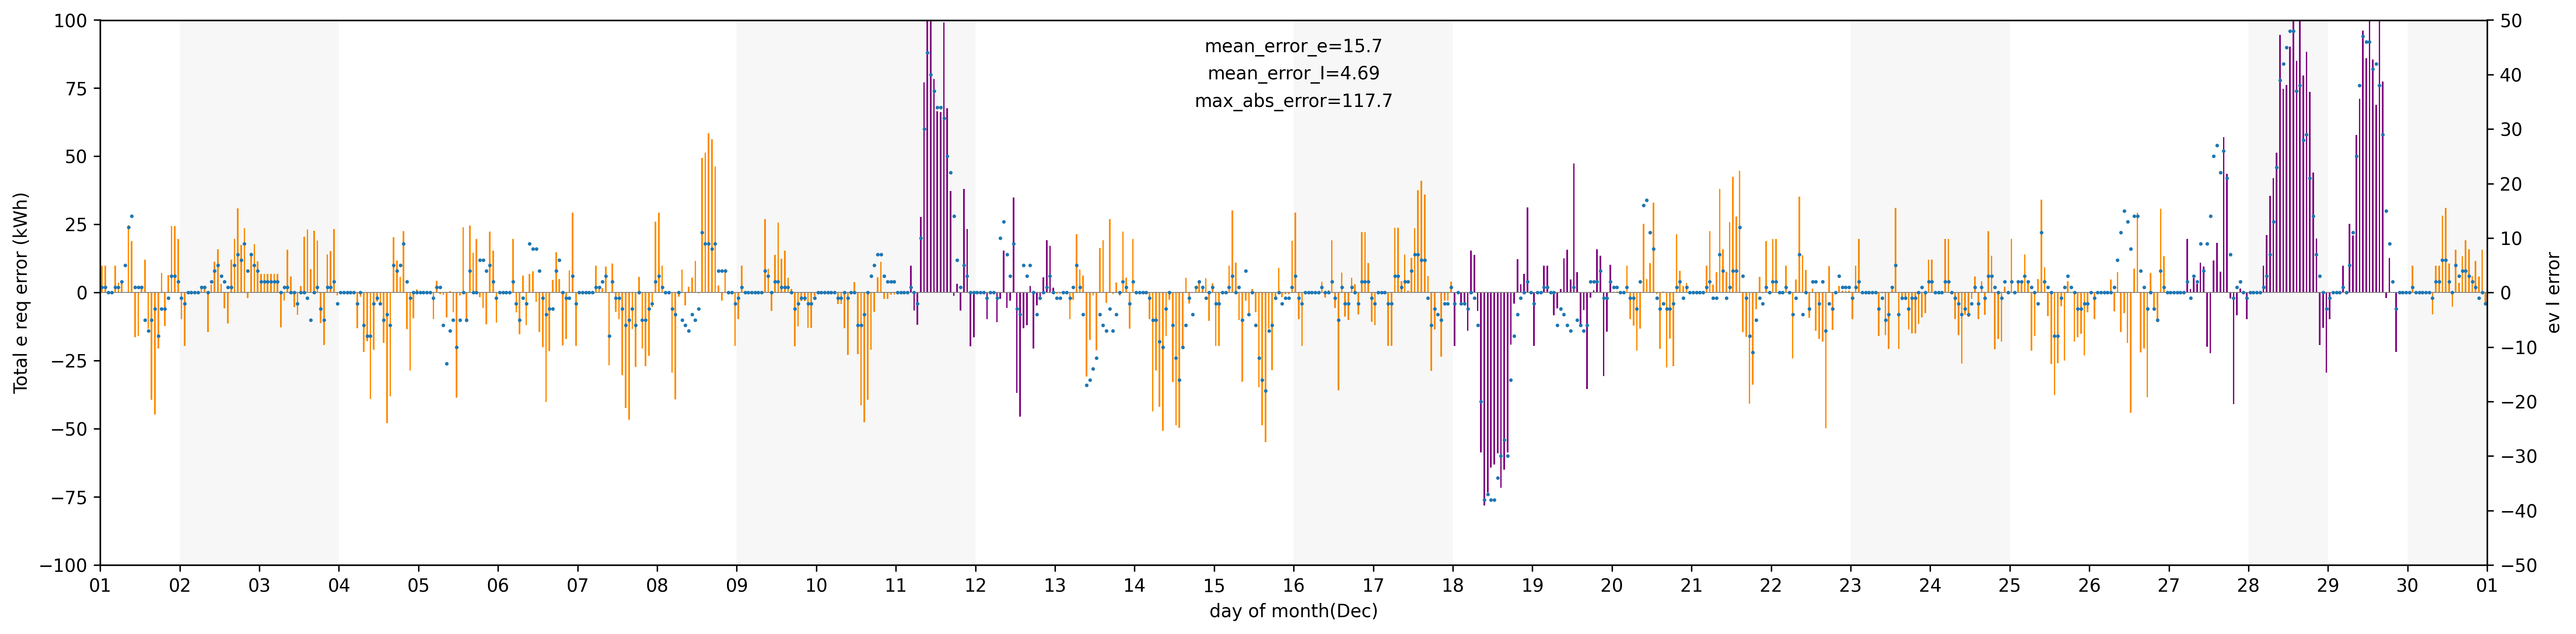

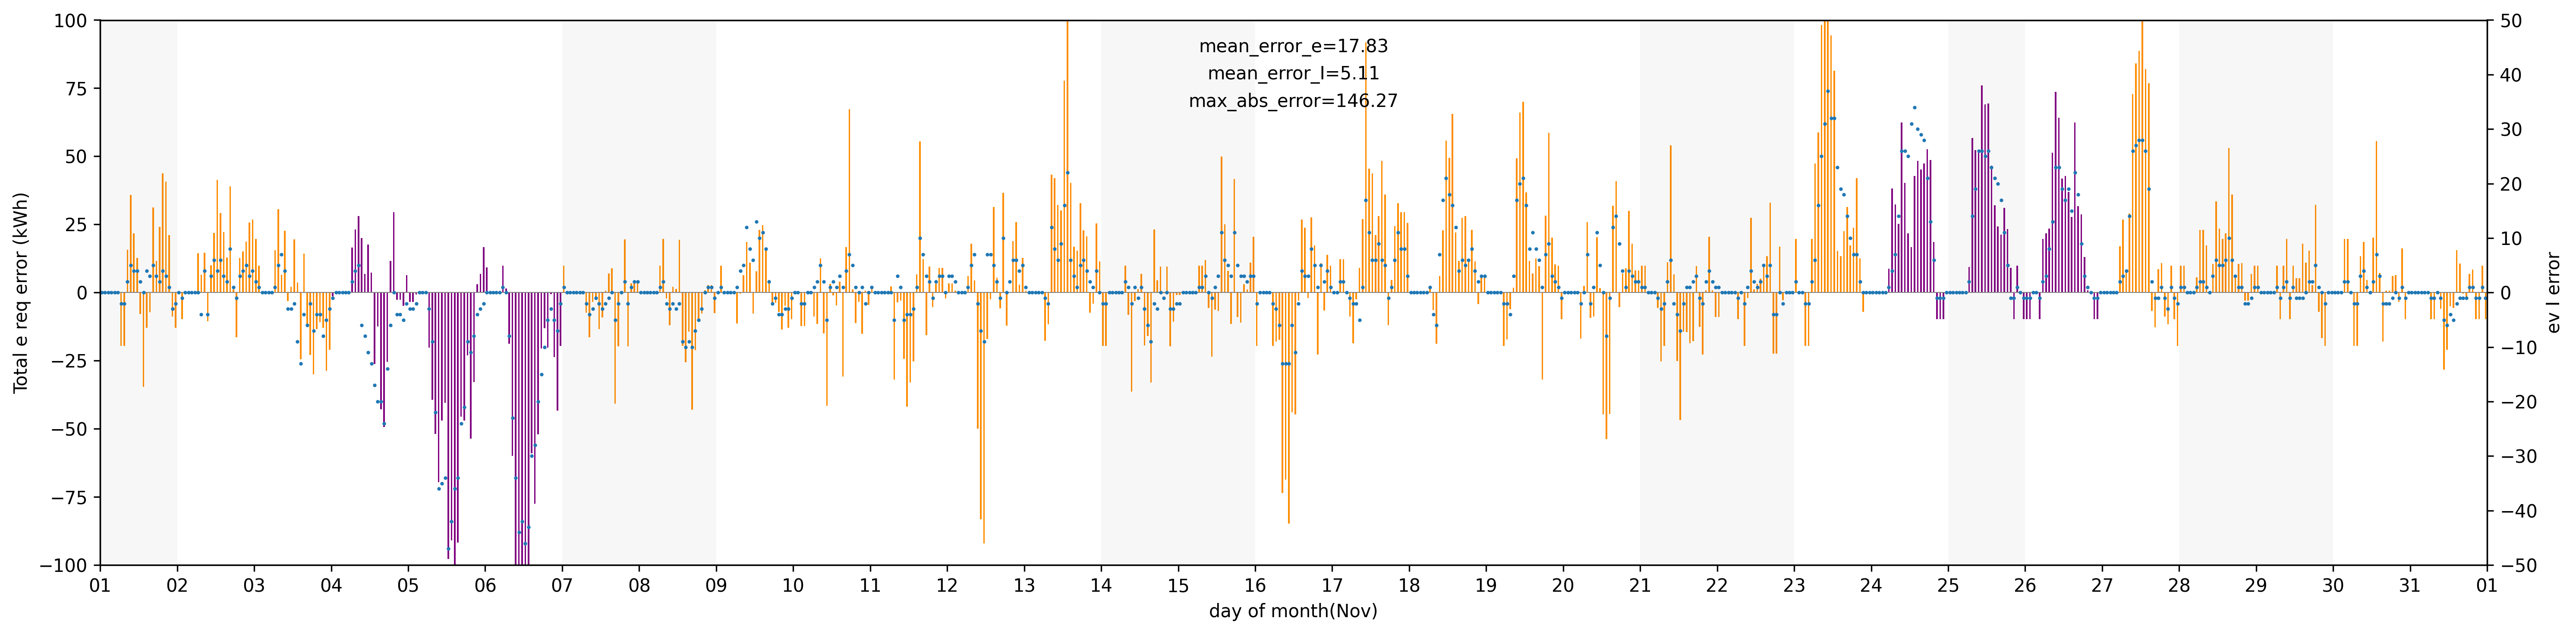

In [6]:
month_n=[1,2,3,4,5,6,7,8,9,10,11,12]
month_l=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Dec','Nov']

#month_n=[9,10,11,12]
#month_l=['Sep','Oct','Dec','Nov']
error=[]
for i in month_n:
    month=month_l[i-1]
    ta=datetime(2019,i,1,0,0)
    
    if i==12:
        td=datetime(2020,1,1,0,0)
    else:
        td=datetime(2019,i+1,1,0,0)
        
    ev_gt=get_gt_ev(ta,td)
    EV_prediction=get_pred_ev(ta,td,24)
    EV_pred_convert=convert_table(ta,td,EV_prediction,1)
    EV_gt_convert=convert_table(ta,td,ev_gt,1)
    error.append(plot_ev_gt_pred(
        EV_pred_convert,
        EV_gt_convert,
        0,None,
        major_interval=24,
        minor_interval=24,
        y_limit_l=[-100,100],
        y_limit_r=[-50,50],
        x_label=month,
        save_fn=month+'.png'
    ))

In [8]:
ave_e=0
ave_I=0
max_e=0
error_df=pd.DataFrame(columns=['target_e','ev_I','max_error','n'])
for i in range(len(error)):
    error_df.loc[i]=error[i]
ave_e=error_df['target_e'].sum()/error_df['n'].sum()
ave_I=error_df['ev_I'].sum()/error_df['n'].sum()
max_e=error_df['max_error'].max()
print(ave_e,ave_I,max_e)

12.428541732141817 3.8437214611872146 146.2650051234419


11.769933441323117 3.4616438356164383 146.2650051234419


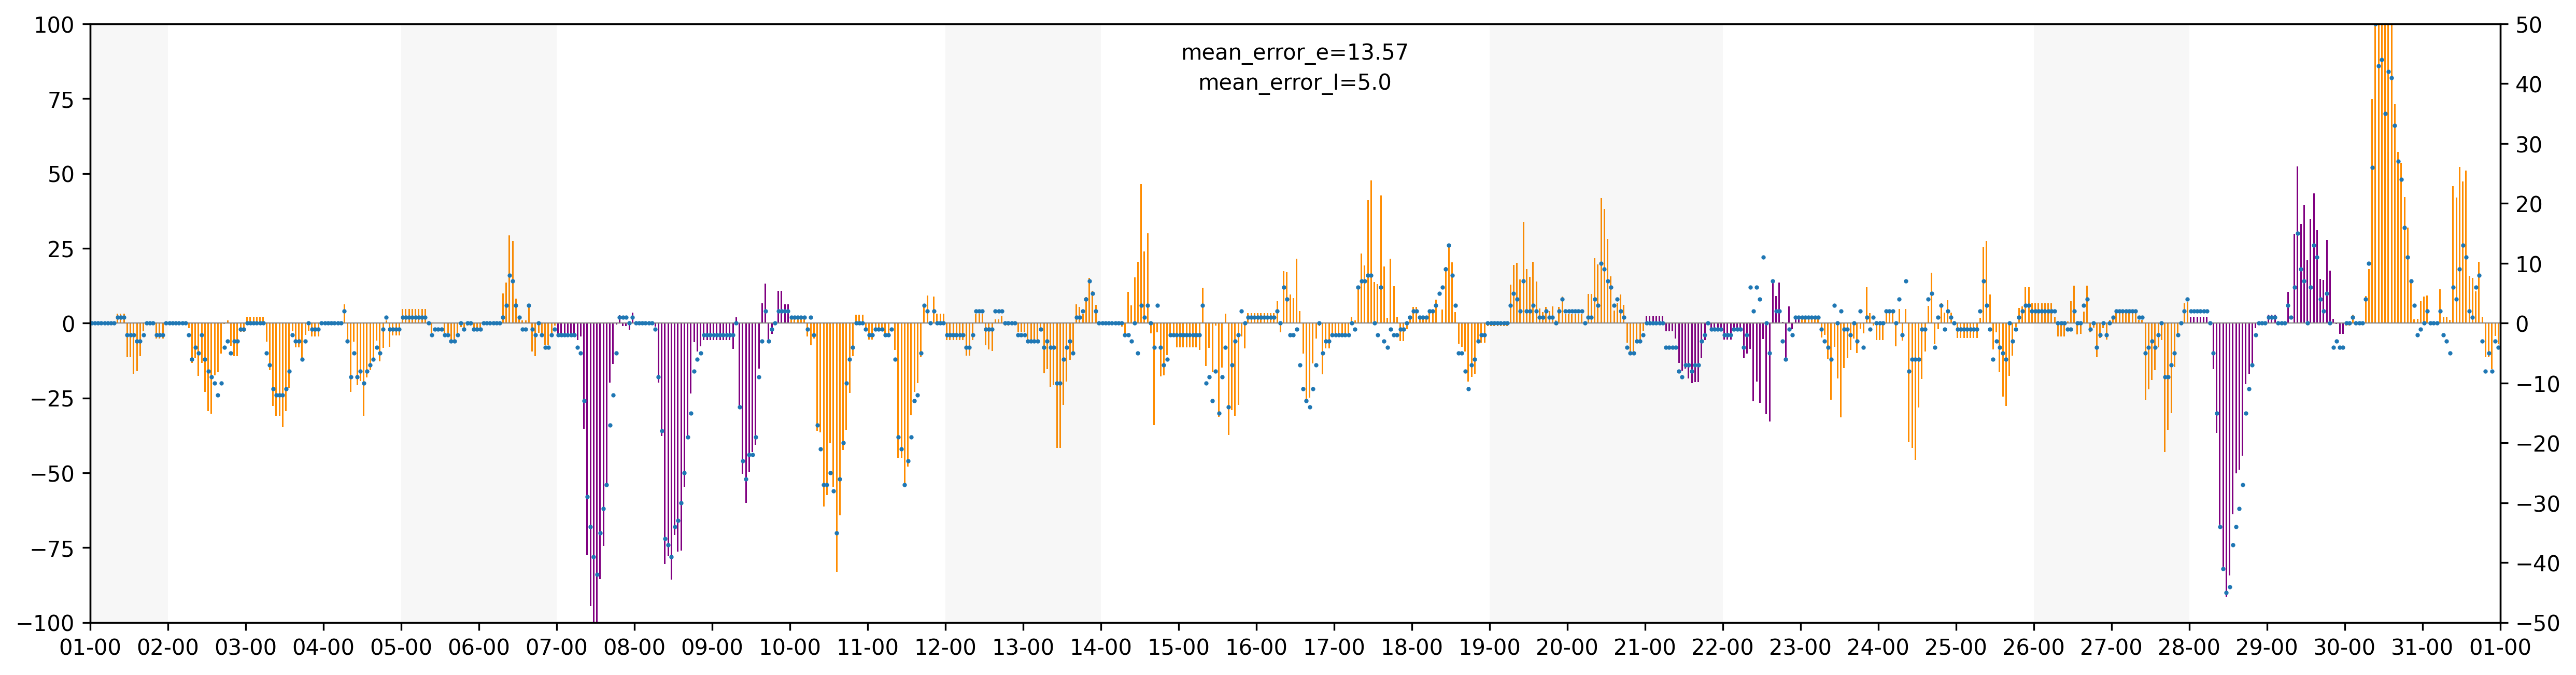

In [ ]:
ta=datetime(2019,1,1,0,0)
td=datetime(2019,2,1,0,0)

ev_gt=get_gt_ev(ta,td)

EV_prediction=get_pred_ev(ta,td,24)
EV_pred_convert=convert_table(ta,td,EV_prediction,1)
EV_gt_convert=convert_table(ta,td,ev_gt,1)

plot_ev_gt_pred(
    EV_pred_convert,
    EV_gt_convert,
    0,None,
    major_interval=24,
    minor_interval=24,
    y_limit_l=[-100,100],
    y_limit_r=[-50,50]
)

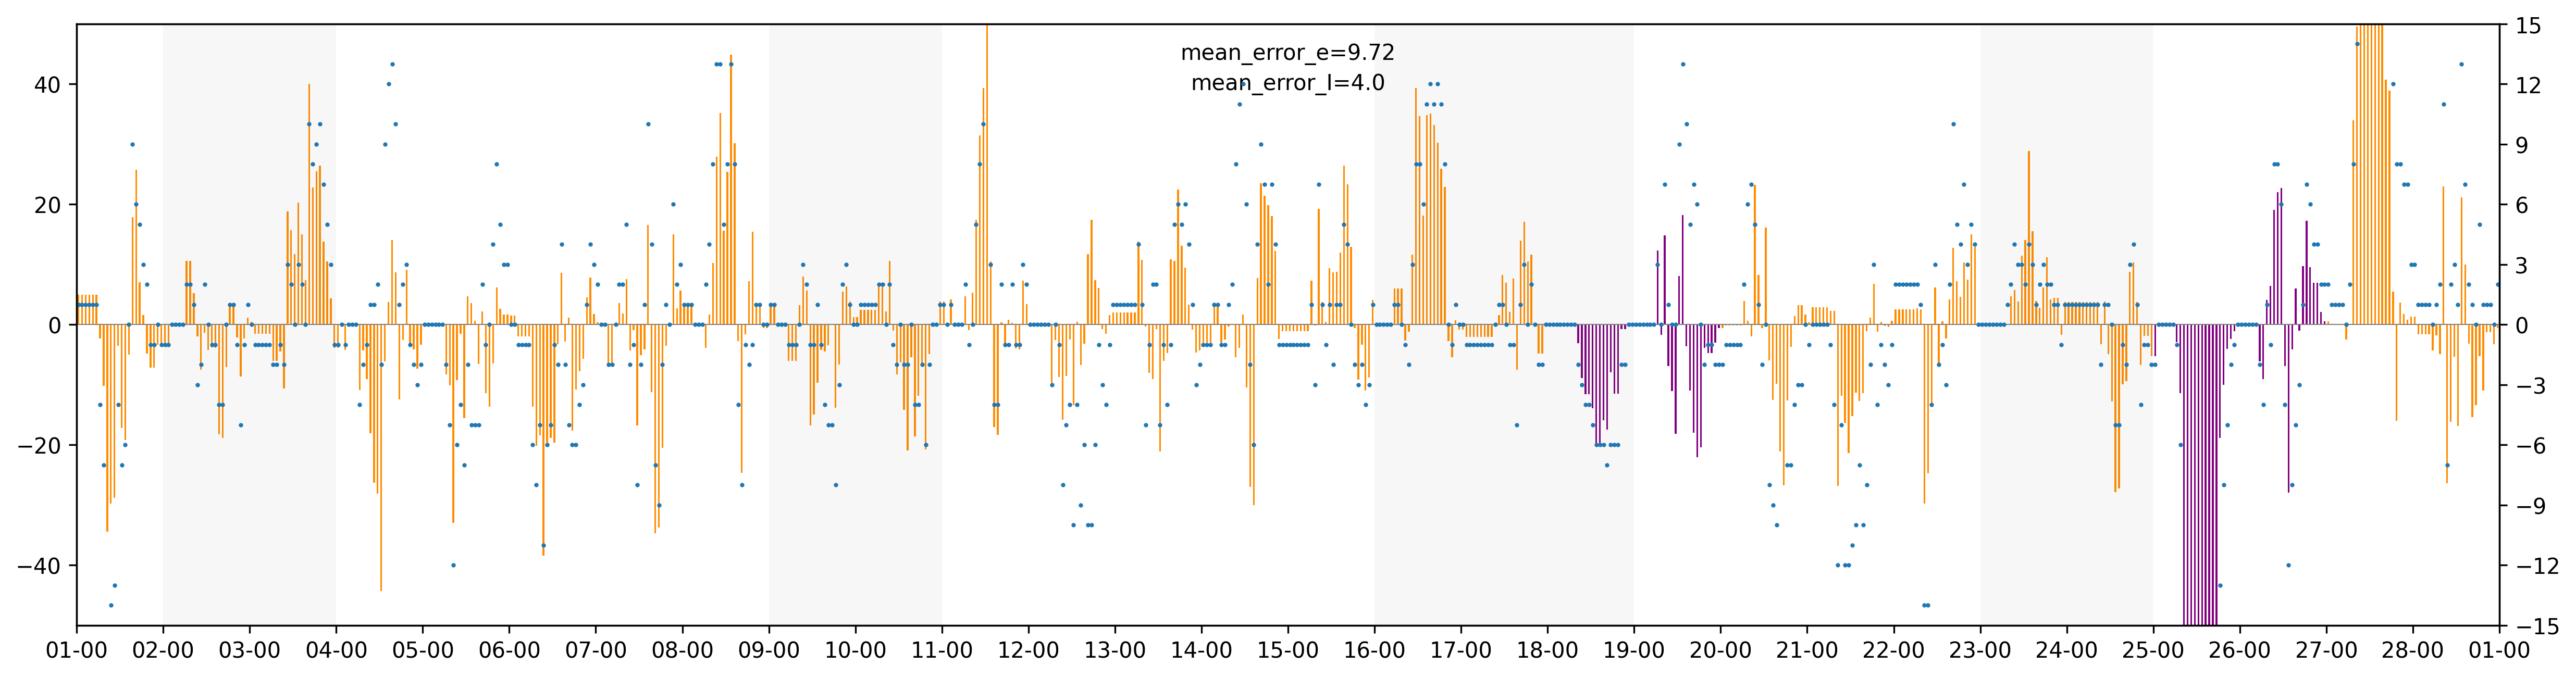

In [ ]:
ta=datetime(2019,2,1,0,0)
td=datetime(2019,3,1,0,0)

ev_gt=get_gt_ev(ta,td)

EV_prediction=get_pred_ev(ta,td,24)
EV_pred_convert=convert_table(ta,td,EV_prediction,1)
EV_gt_convert=convert_table(ta,td,ev_gt,1)

plot_ev_gt_pred(
    EV_pred_convert,
    EV_gt_convert,
    0,None,
    major_interval=24,
    minor_interval=24,
)

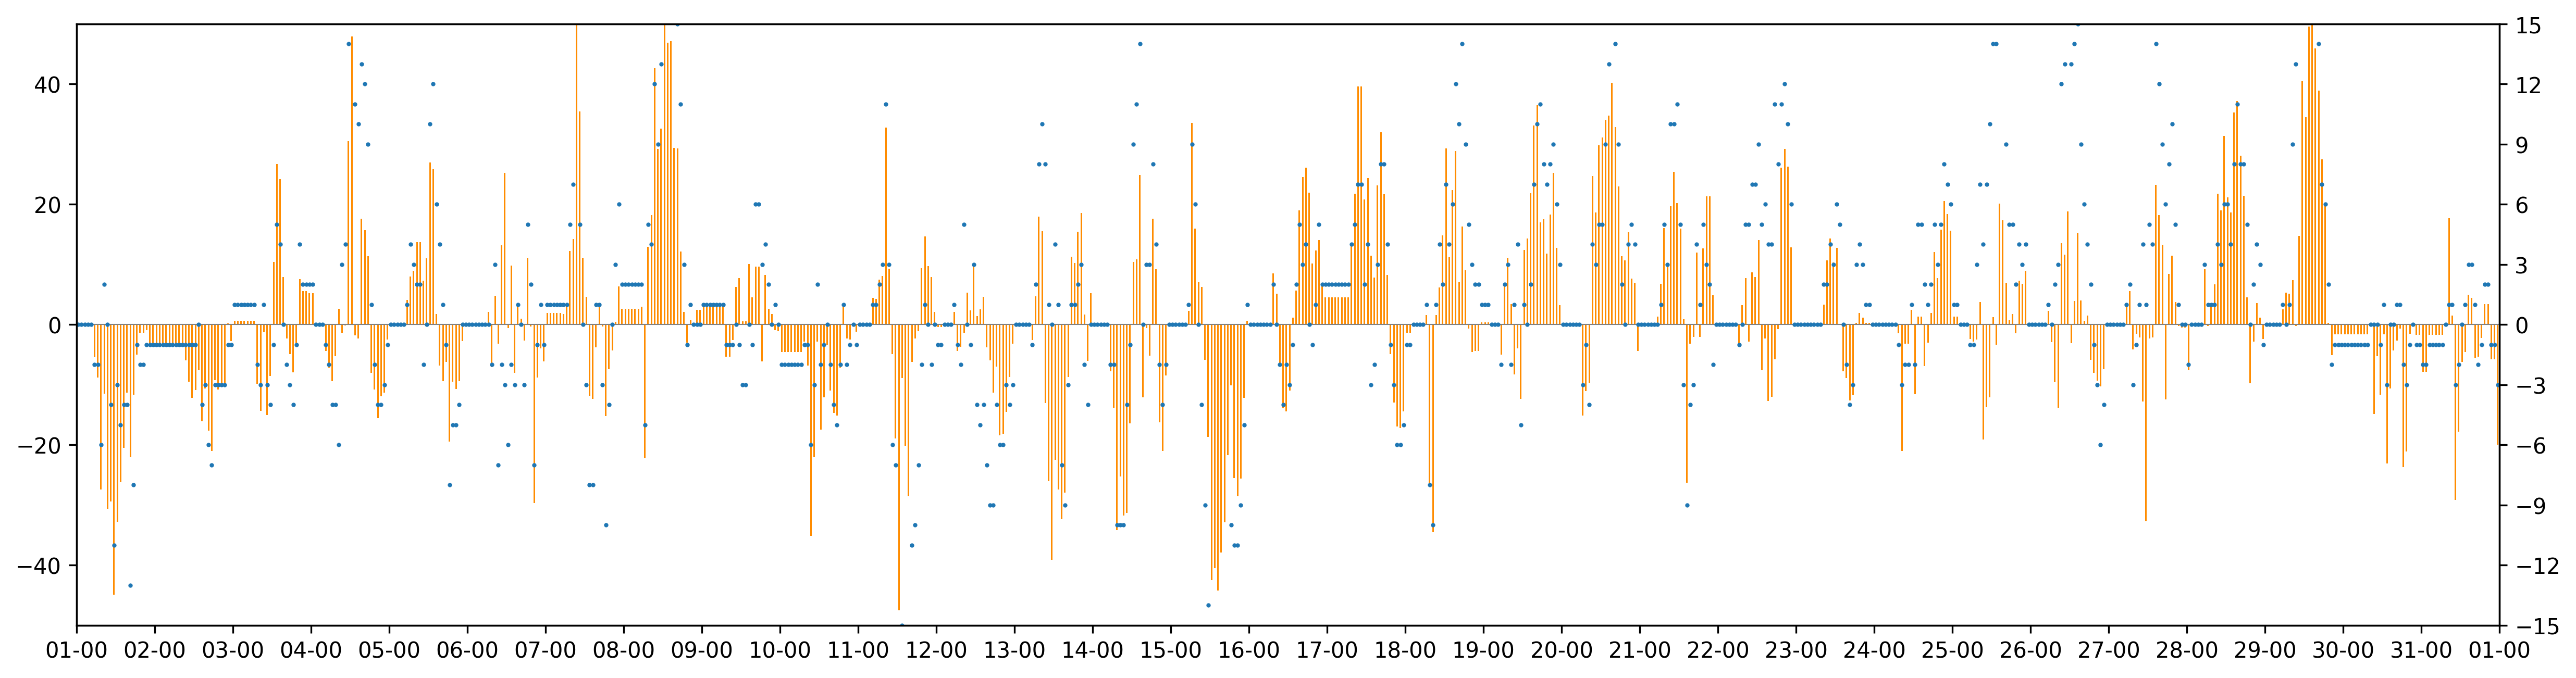

In [ ]:
ta=datetime(2019,3,1,0,0)
td=datetime(2019,4,1,0,0)

ev_gt=get_gt_ev(ta,td)

EV_prediction=get_pred_ev(ta,td,24)
EV_pred_convert=convert_table(ta,td,EV_prediction,1)
EV_gt_convert=convert_table(ta,td,ev_gt,1)

plot_ev_gt_pred(
    EV_pred_convert,
    EV_gt_convert,
    0,None,
    major_interval=24,
    minor_interval=24,
)

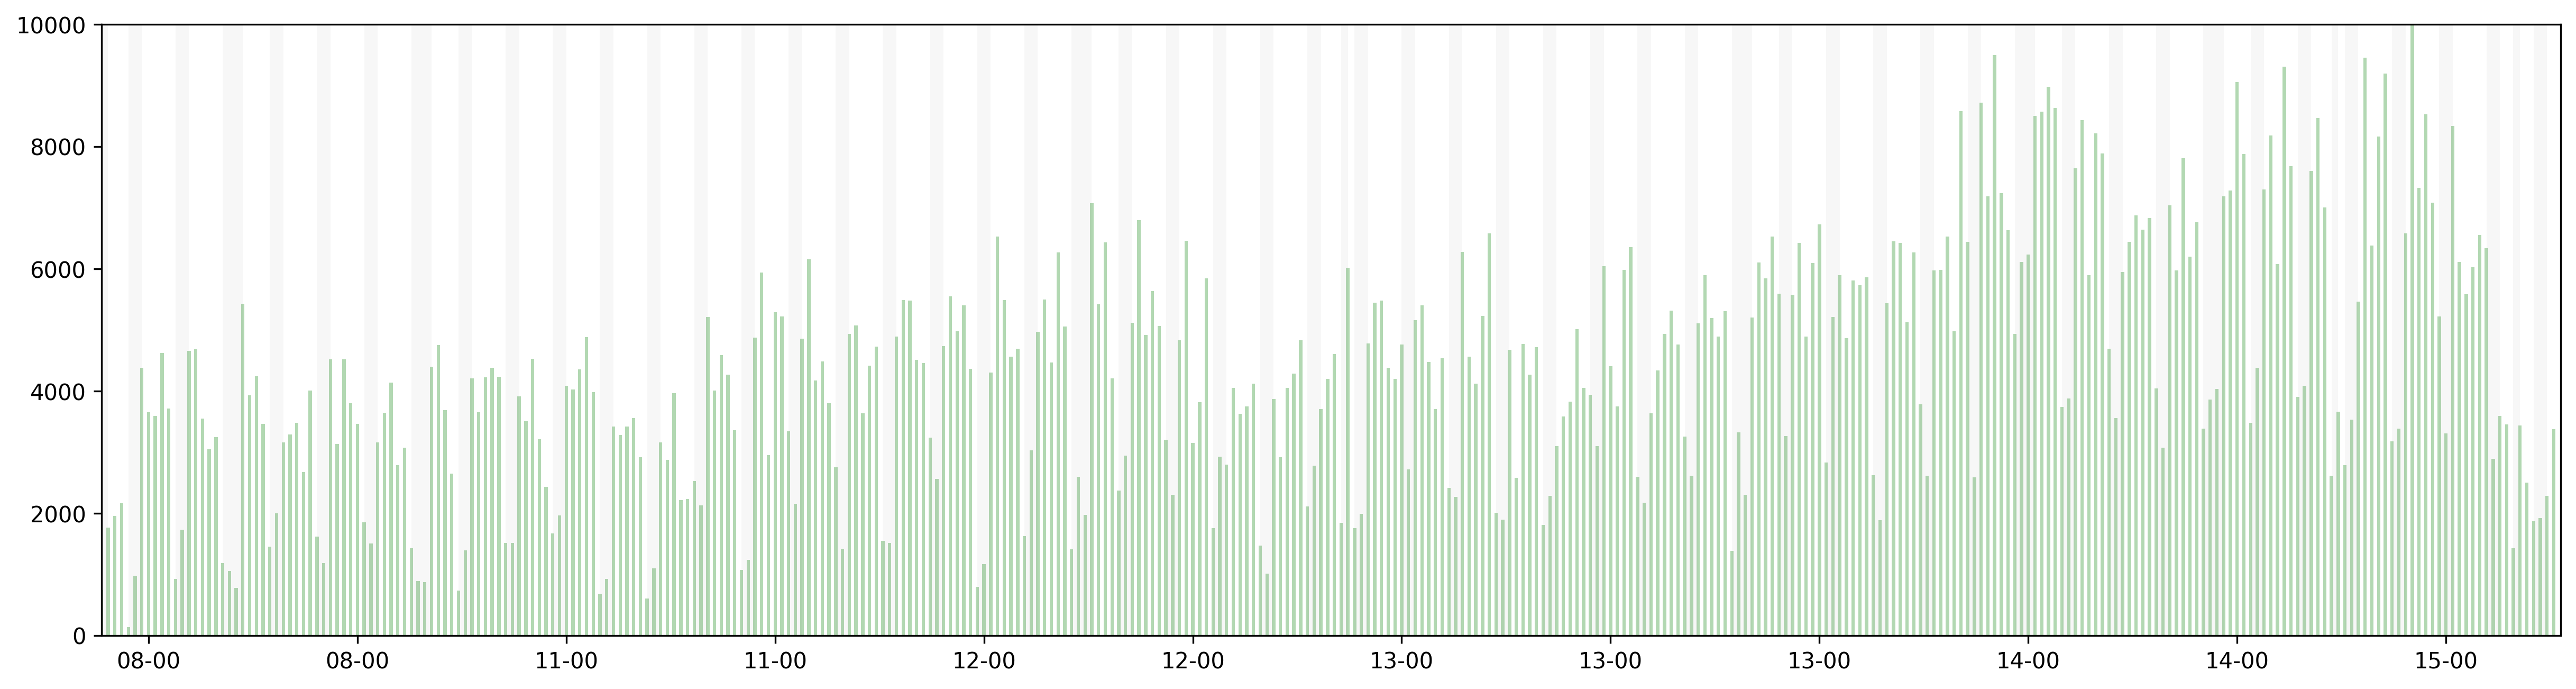

In [ ]:
ta=datetime(2019,1,1,0,0)
td=datetime(2020,1,1,0,0)

ev_gt=get_gt_ev(ta,td)

EV_prediction=get_pred_ev(ta,td,24)
EV_pred_convert=convert_table(ta,td,EV_prediction,24)
EV_gt_convert=convert_table(ta,td,ev_gt,24)

plot_ev_gt_pred(
    EV_pred_convert,
    EV_gt_convert,
    0,None,
    major_interval=24*31,
    minor_interval=24*31,
    y_limit_l=[0,10000],
    y_limit_r=[0,50],
    display_error=False,
    bar_width=0.5
)

(0, 0, 0, 0)

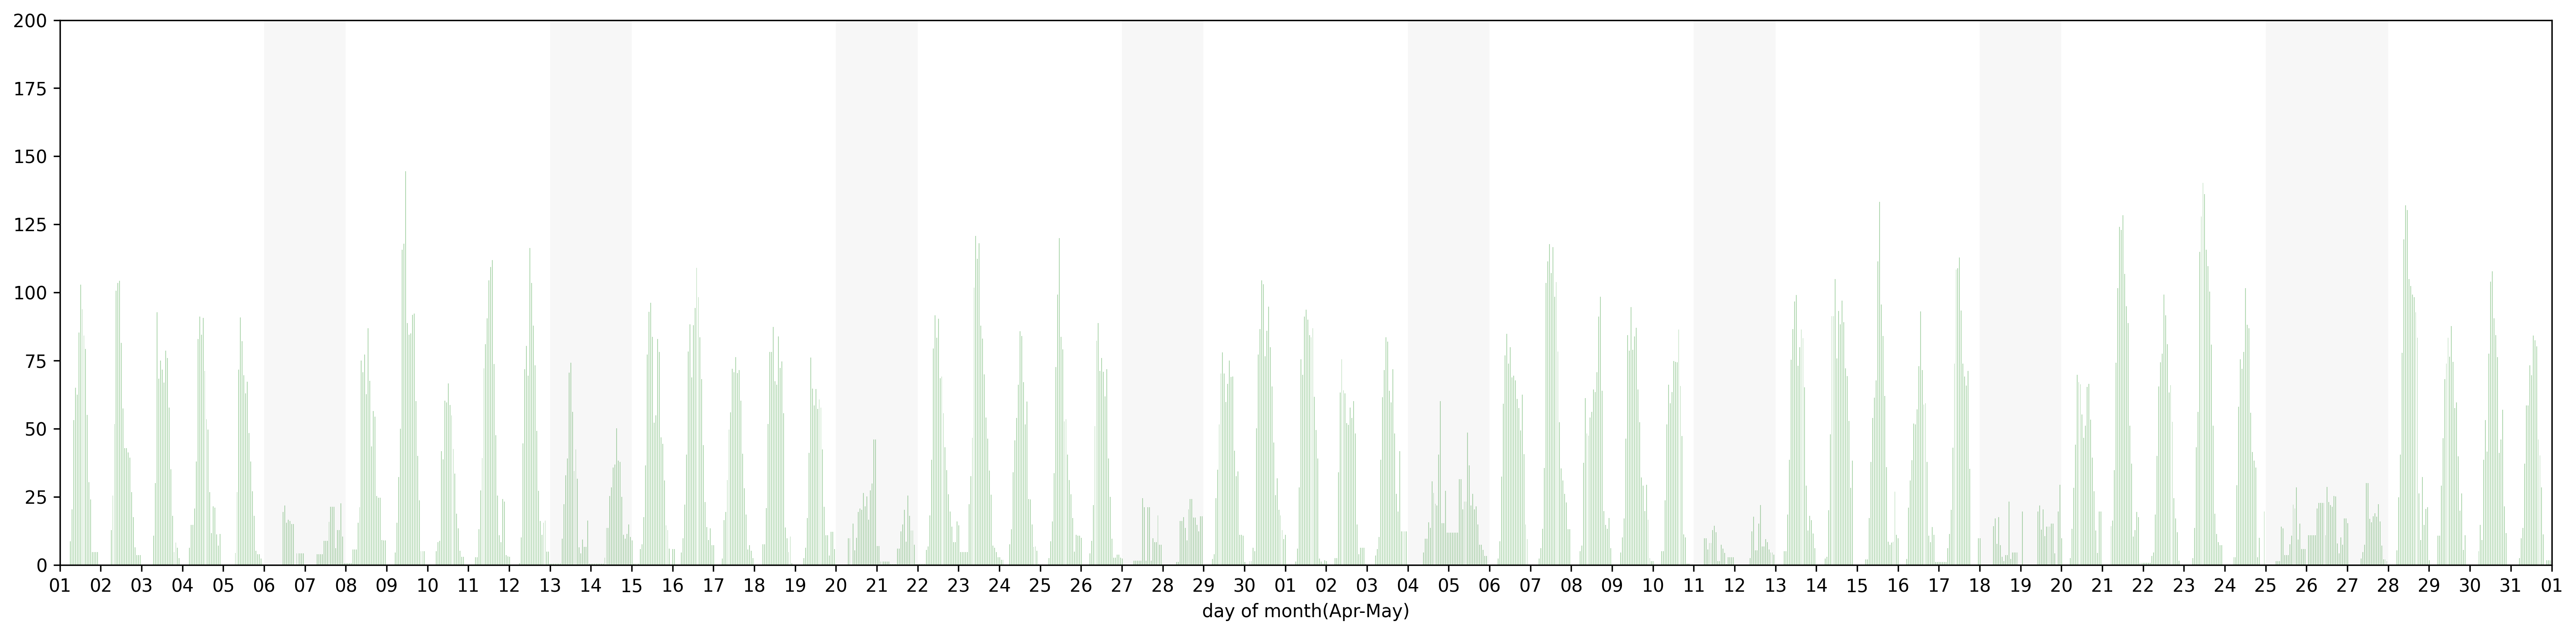

In [15]:
ta=datetime(2019,4,1,0,0)
td=datetime(2019,6,1,0,0)

ev_gt=get_gt_ev(ta,td)

EV_prediction=get_pred_ev(ta,td,24)
EV_pred_convert=convert_table(ta,td,EV_prediction,1)
EV_gt_convert=convert_table(ta,td,ev_gt,1)

plot_ev_gt_pred(
    EV_pred_convert,
    EV_gt_convert,
    0,None,
    major_interval=24,
    minor_interval=24,
    y_limit_l=[0,200],
    y_limit_r=[0,50],
    display_error=False,
    x_label='Apr-May'
)

(0, 0, 0, 0)

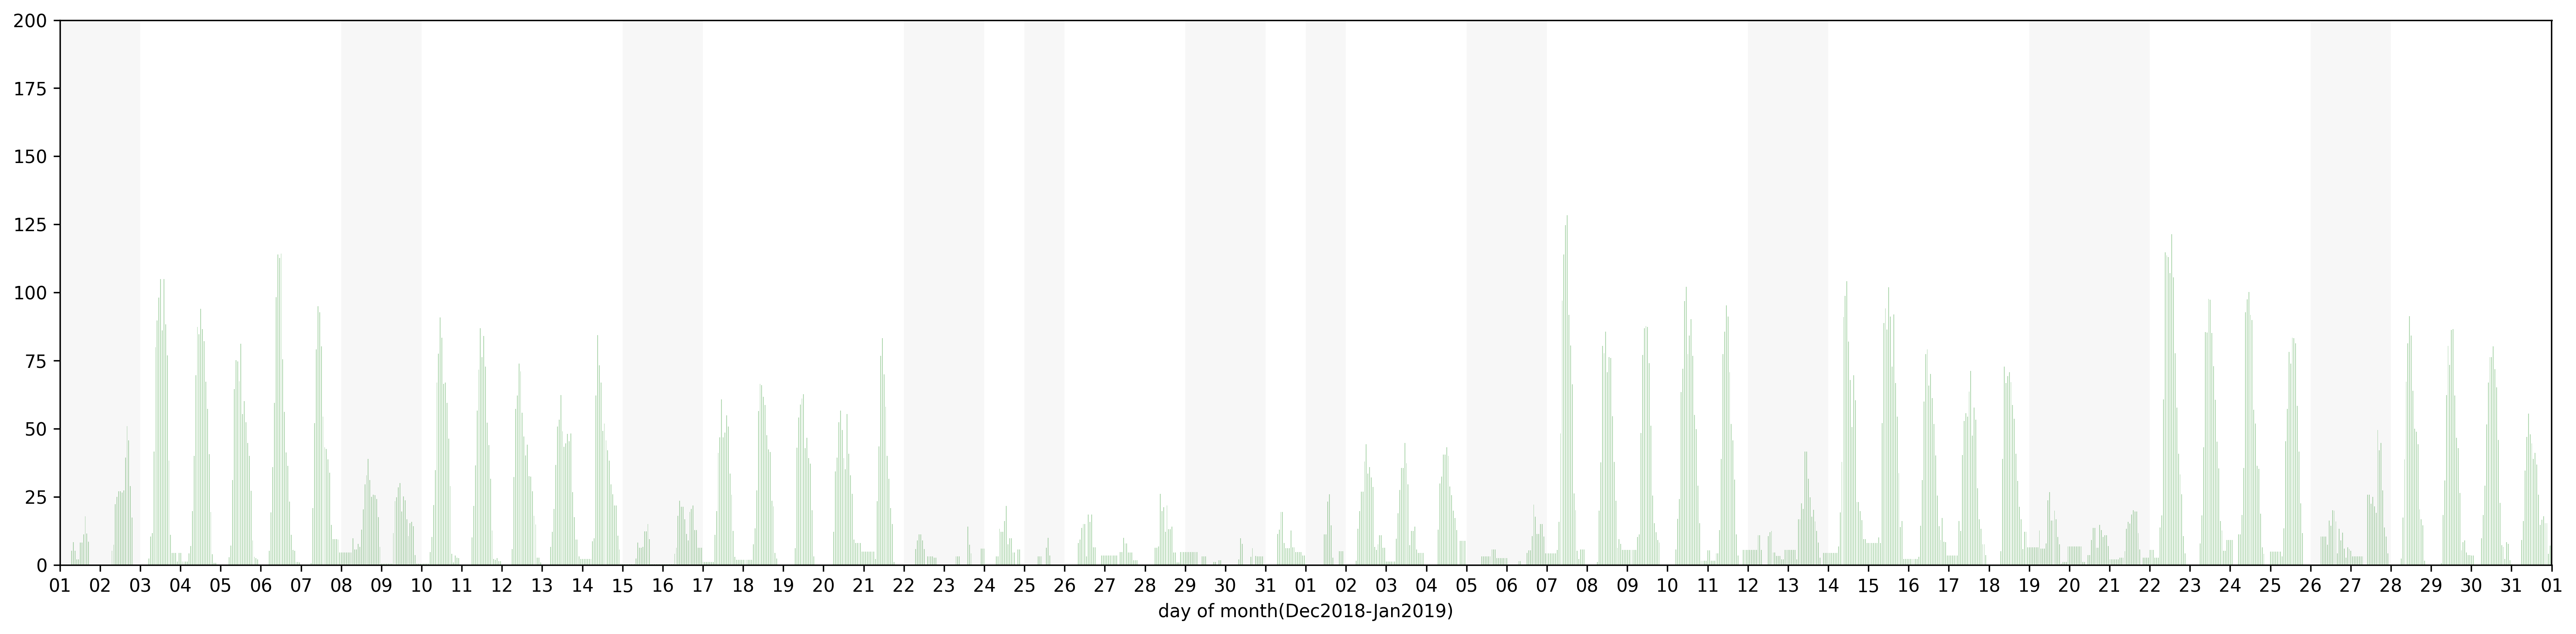

In [16]:
ta=datetime(2018,12,1,0,0)
td=datetime(2019,2,1,0,0)

ev_gt=get_gt_ev(ta,td)

EV_prediction=get_pred_ev(ta,td,24)
EV_pred_convert=convert_table(ta,td,EV_prediction,1)
EV_gt_convert=convert_table(ta,td,ev_gt,1)

plot_ev_gt_pred(
    EV_pred_convert,
    EV_gt_convert,
    0,None,
    major_interval=24,
    minor_interval=24,
    y_limit_l=[0,200],
    y_limit_r=[0,50],
    display_error=False,
    x_label='Dec2018-Jan2019'
)

# -1 week error

(8687.379250982838, 2455, 86.20774718733927, 744)

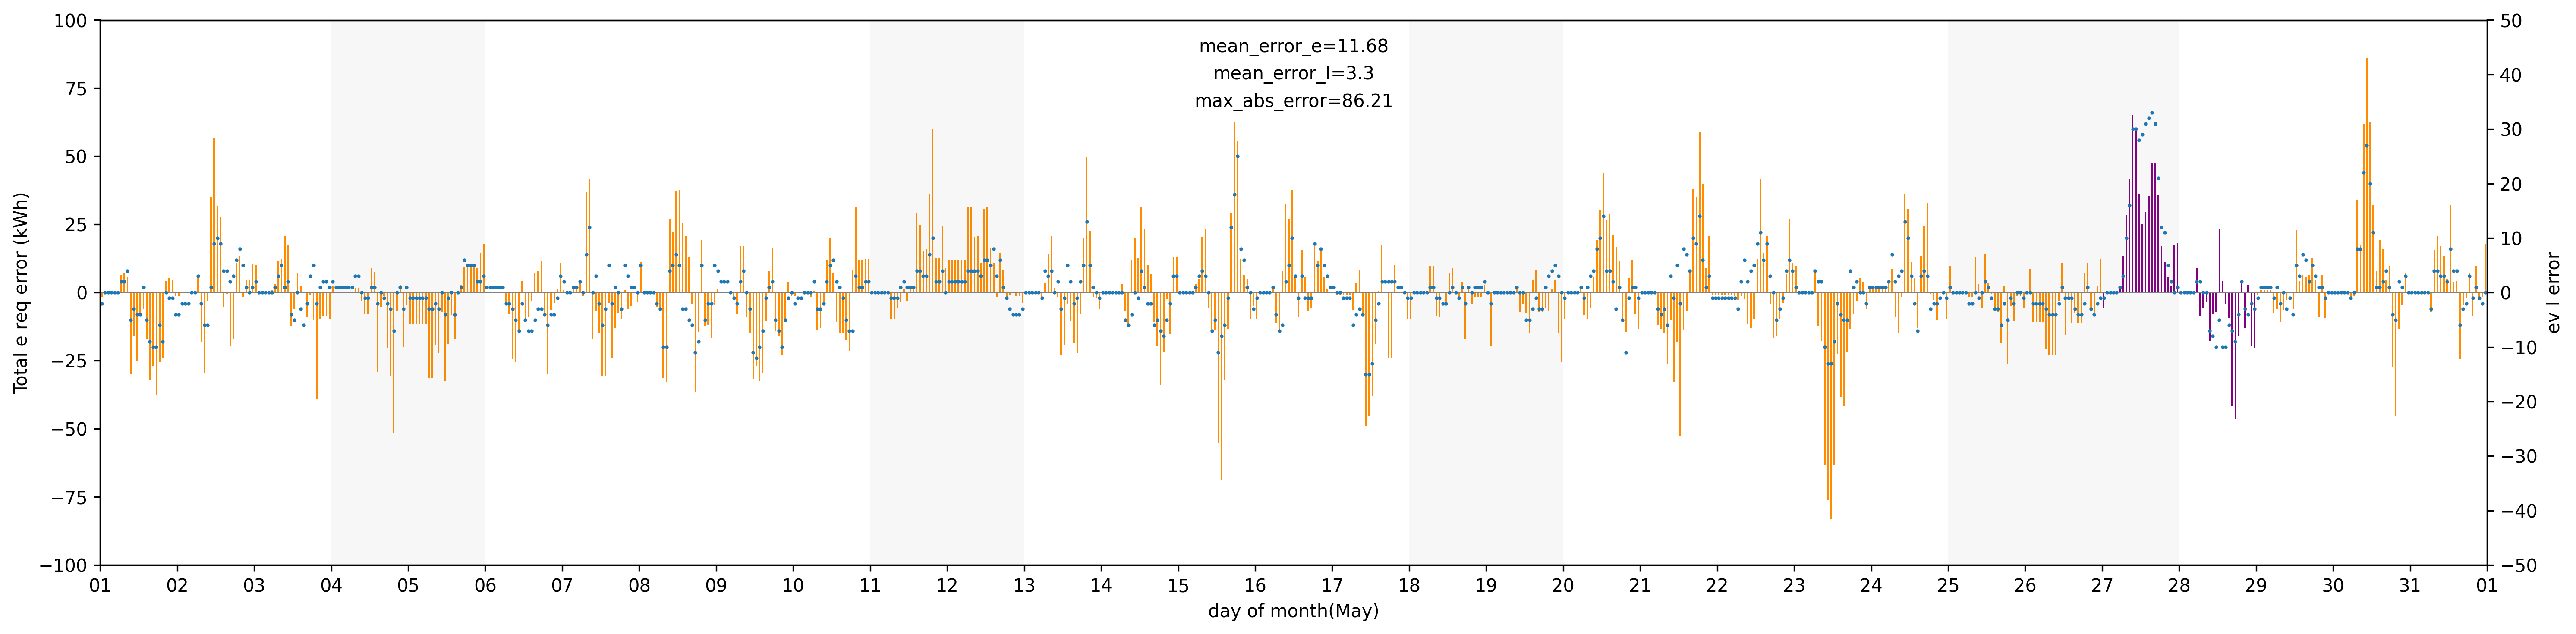

In [11]:
ta=datetime(2019,5,1,0,0)
td=datetime(2019,6,1,0,0)

ev_gt=get_gt_ev(ta,td)
ev_gt_1week=get_gt_ev(ta-timedelta(days=7),td-timedelta(days=7))

EV_pred_convert=convert_table(ta-timedelta(days=7),td-timedelta(days=7),ev_gt_1week,1)
EV_gt_convert=convert_table(ta,td,ev_gt,1)

plot_ev_gt_pred(
    EV_pred_convert,
    EV_gt_convert,
    None,None,
    major_interval=24,
    minor_interval=24,
    y_limit_l=[-100,100],
    y_limit_r=[-50,50],
    display_error=True,
    x_label='May'
)

(13649.957420716904, 4719, 124.5397919053839, 744)

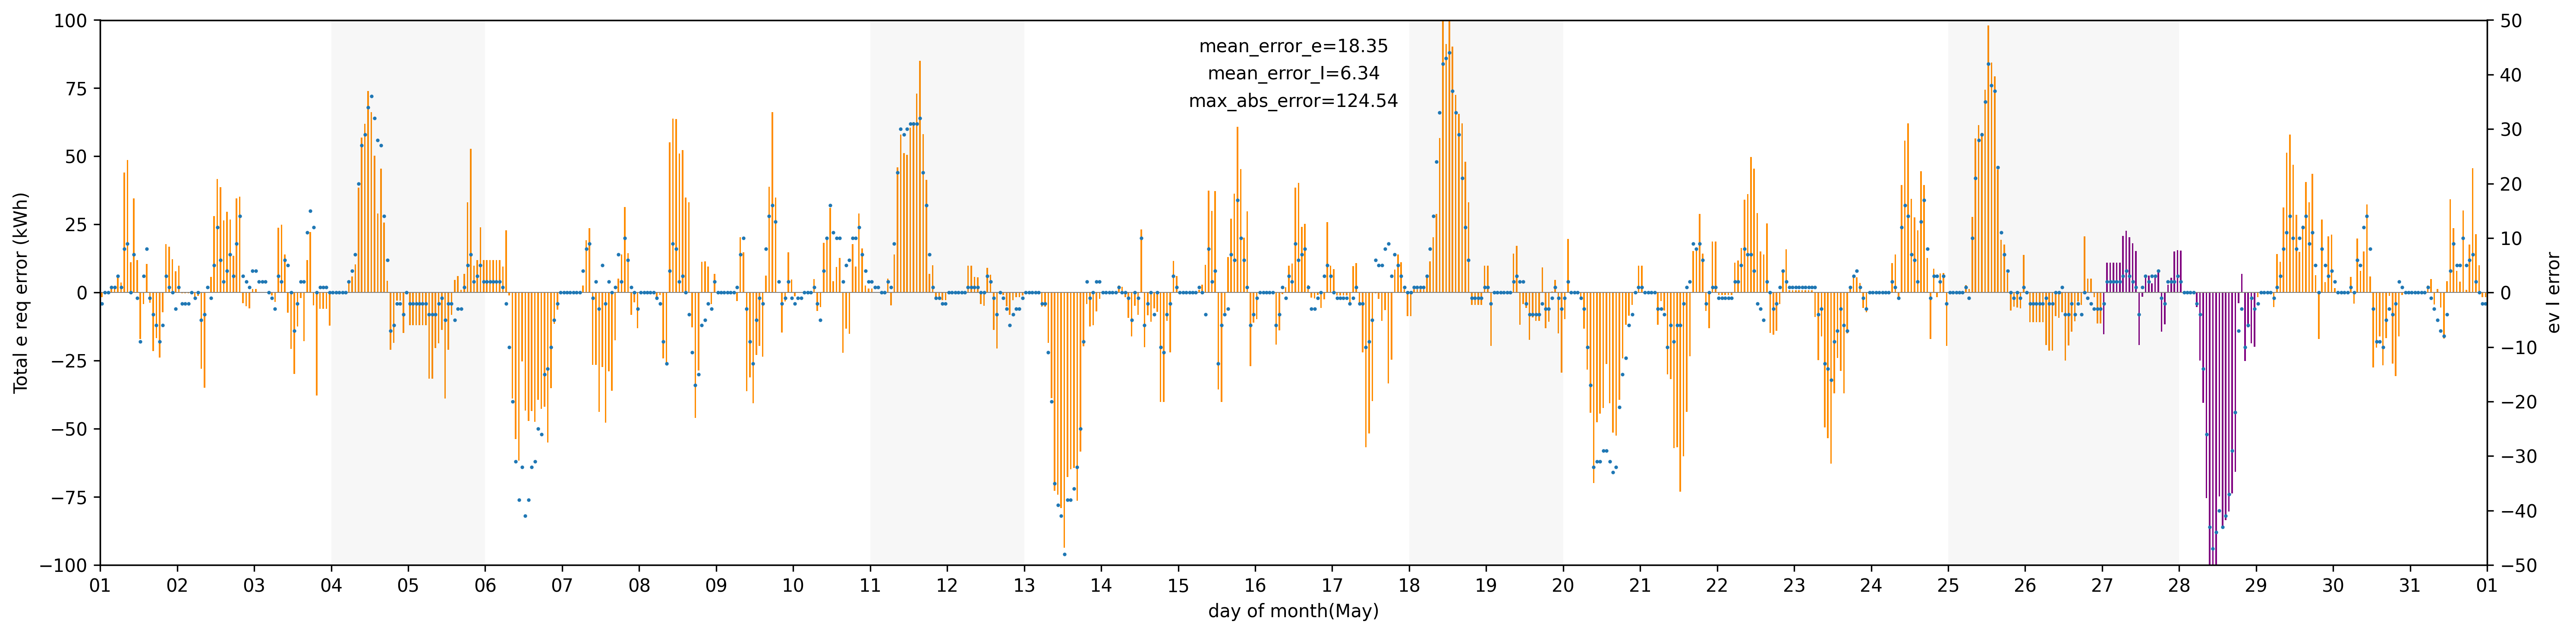

In [13]:
ta=datetime(2019,5,1,0,0)
td=datetime(2019,6,1,0,0)

ev_gt=get_gt_ev(ta,td)
ev_gt_1week=get_gt_ev(ta-timedelta(days=1),td-timedelta(days=1))

EV_pred_convert=convert_table(ta-timedelta(days=1),td-timedelta(days=1),ev_gt_1week,1)
EV_gt_convert=convert_table(ta,td,ev_gt,1)

plot_ev_gt_pred(
    EV_pred_convert,
    EV_gt_convert,
    None,None,
    major_interval=24,
    minor_interval=24,
    y_limit_l=[-100,100],
    y_limit_r=[-50,50],
    display_error=True,
    x_label='May'
)

TypeError: can only concatenate str (not "NoneType") to str

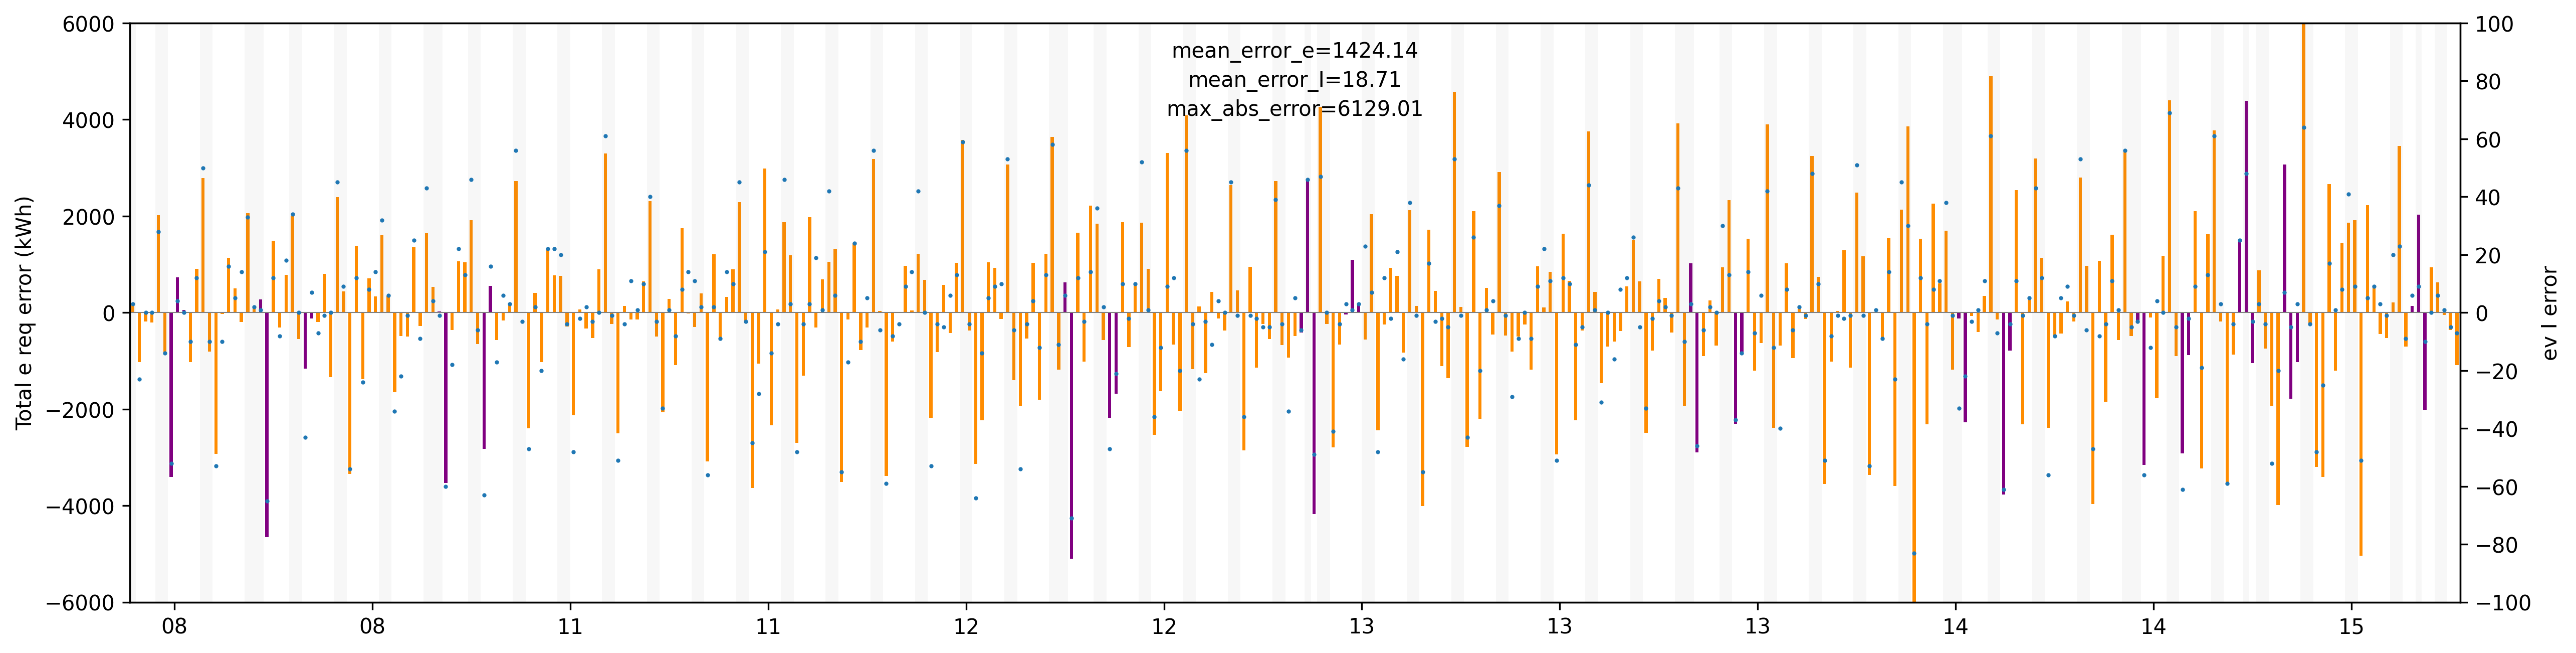

In [12]:
ta=datetime(2019,1,1,0,0)
td=datetime(2020,1,1,0,0)

ev_gt=get_gt_ev(ta,td)
ev_gt_1week=get_gt_ev(ta-timedelta(days=1),td-timedelta(days=1))

EV_pred_convert=convert_table(ta-timedelta(days=1),td-timedelta(days=1),ev_gt_1week,24)
EV_gt_convert=convert_table(ta,td,ev_gt,24)

plot_ev_gt_pred(
    EV_pred_convert,
    EV_gt_convert,
    None,None,
    major_interval=24*31,
    minor_interval=24*31,
    y_limit_l=[-6000,6000],
    y_limit_r=[-100,100],
    display_error=True,
    bar_width=0.5
)

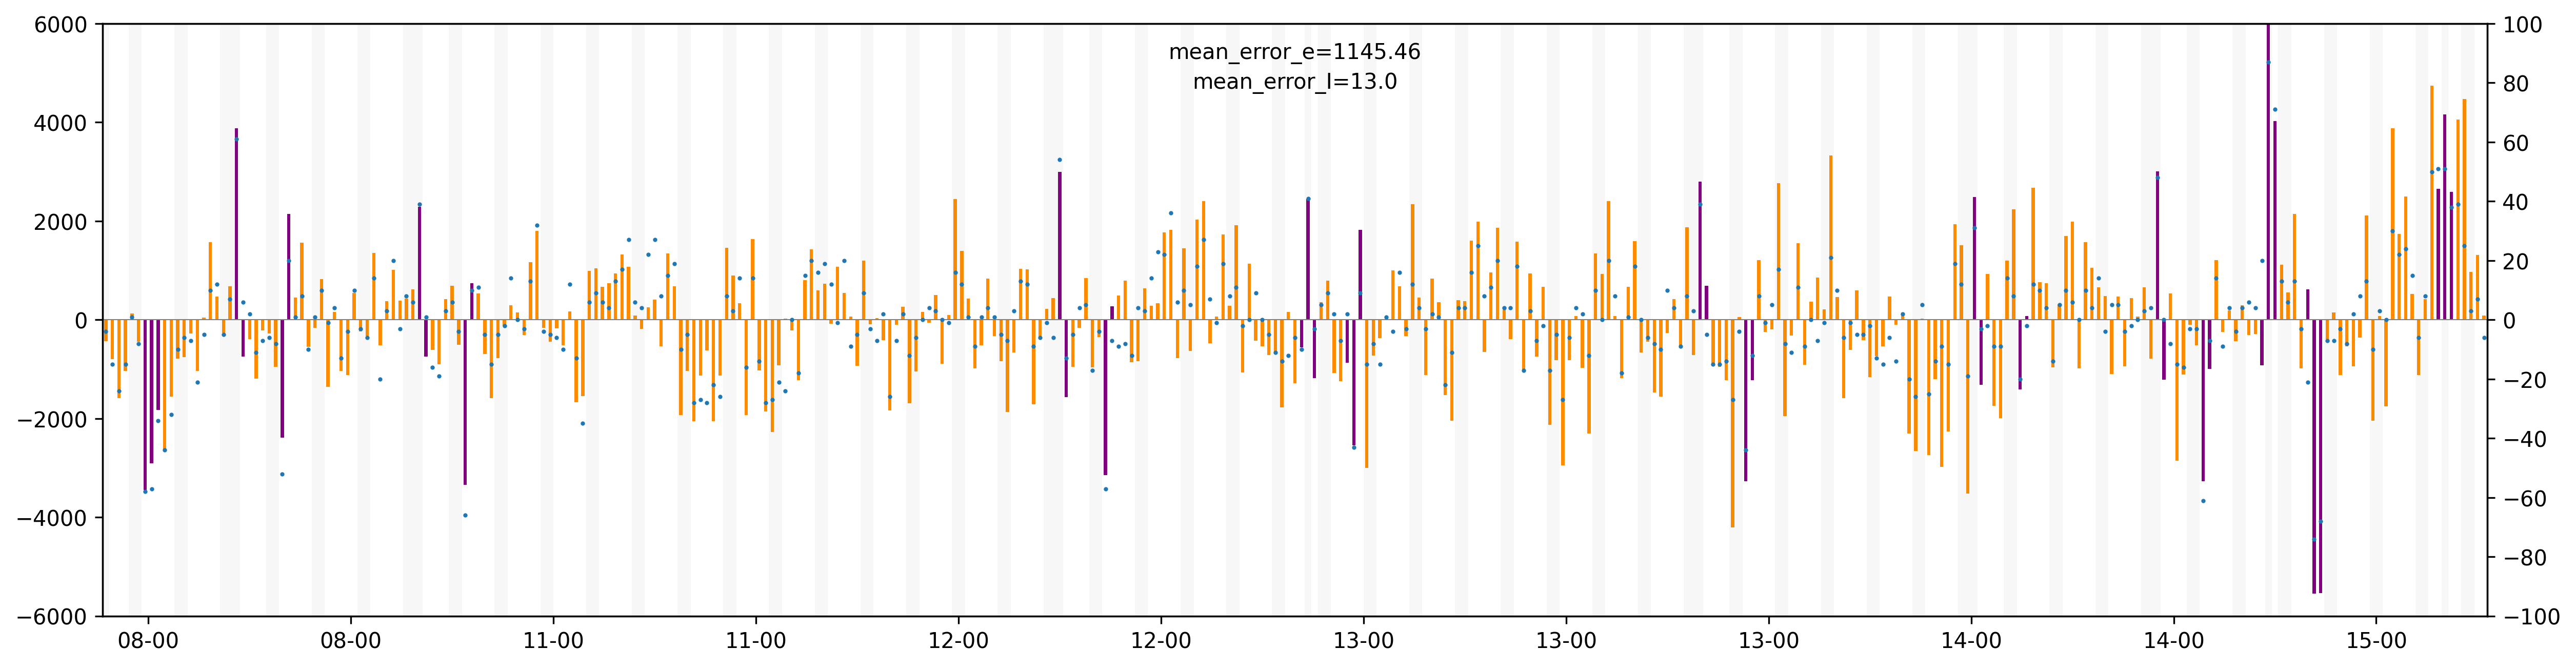

In [ ]:
ta=datetime(2019,1,1,0,0)
td=datetime(2020,1,1,0,0)

ev_gt=get_gt_ev(ta,td)
ev_gt_1week=get_gt_ev(ta-timedelta(days=7),td-timedelta(days=7))

EV_pred_convert=convert_table(ta-timedelta(days=7),td-timedelta(days=7),ev_gt_1week,24)
EV_gt_convert=convert_table(ta,td,ev_gt,24)

plot_ev_gt_pred(
    EV_pred_convert,
    EV_gt_convert,
    None,None,
    major_interval=24*31,
    minor_interval=24*31,
    y_limit_l=[-6000,6000],
    y_limit_r=[-100,100],
    display_error=True,
    bar_width=0.5
)

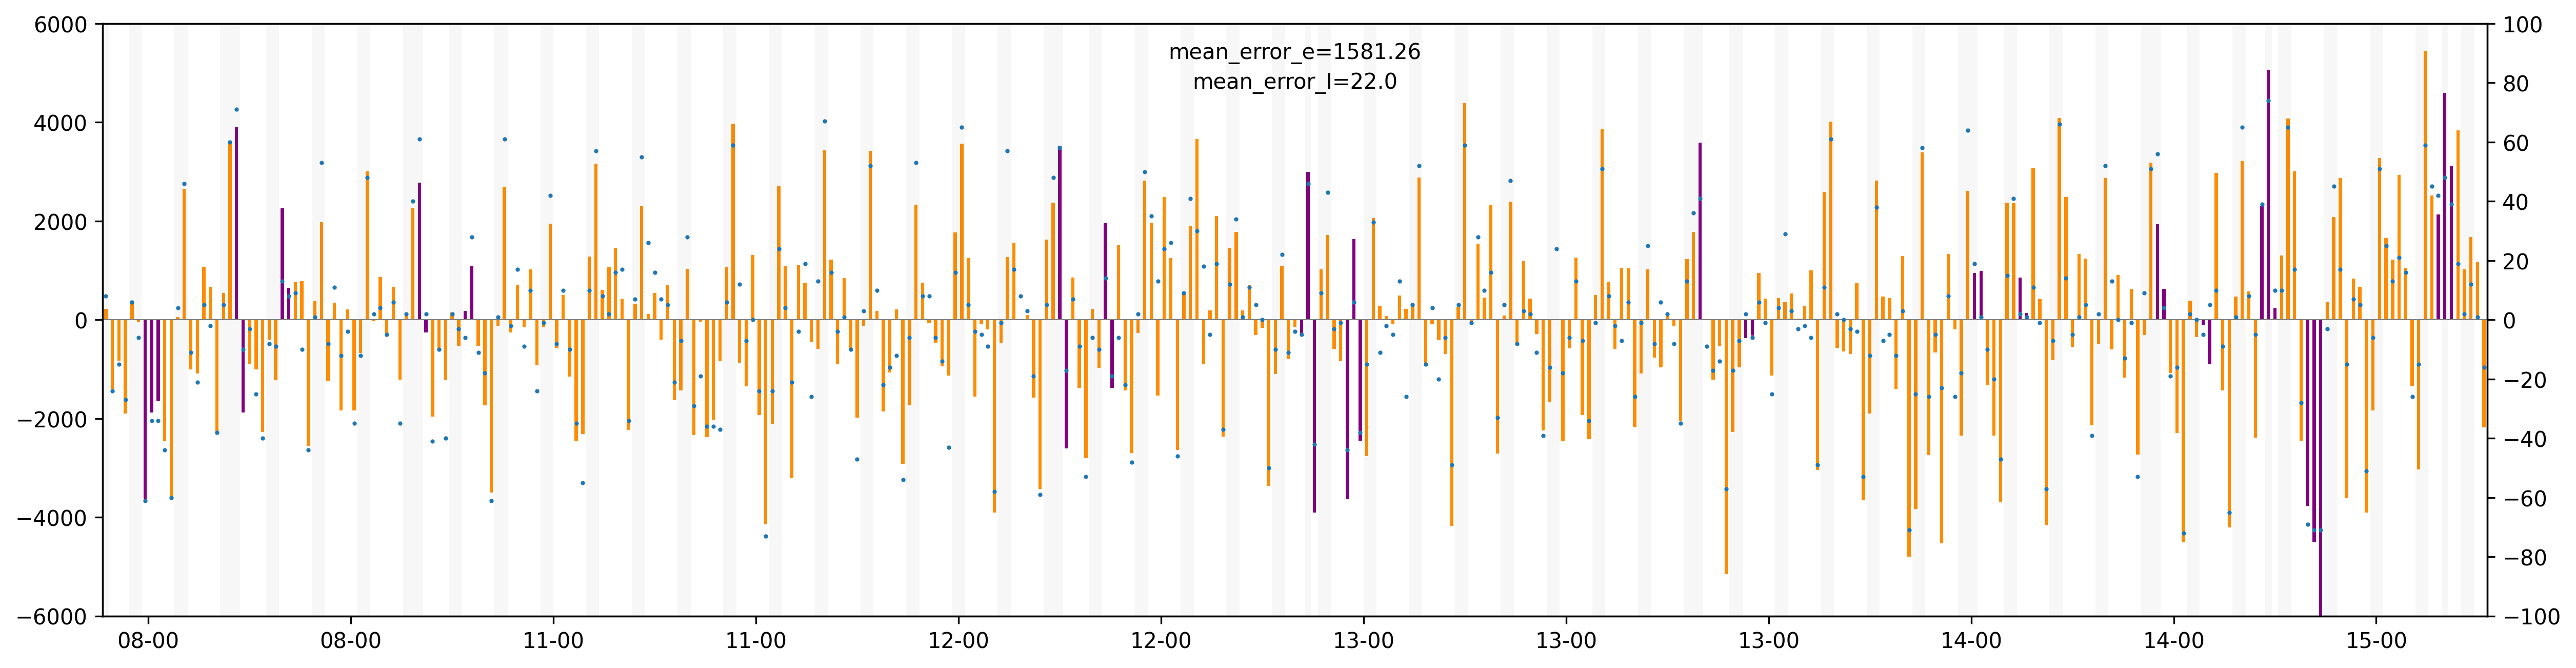

In [ ]:
ta=datetime(2019,1,1,0,0)
td=datetime(2020,1,1,0,0)

ev_gt=get_gt_ev(ta,td)
ev_gt_1week=get_gt_ev(ta-timedelta(days=6),td-timedelta(days=6))

EV_pred_convert=convert_table(ta-timedelta(days=6),td-timedelta(days=6),ev_gt_1week,24)
EV_gt_convert=convert_table(ta,td,ev_gt,24)

plot_ev_gt_pred(
    EV_pred_convert,
    EV_gt_convert,
    None,None,
    major_interval=24*31,
    minor_interval=24*31,
    y_limit_l=[-6000,6000],
    y_limit_r=[-100,100],
    display_error=True,
    bar_width=0.5
)

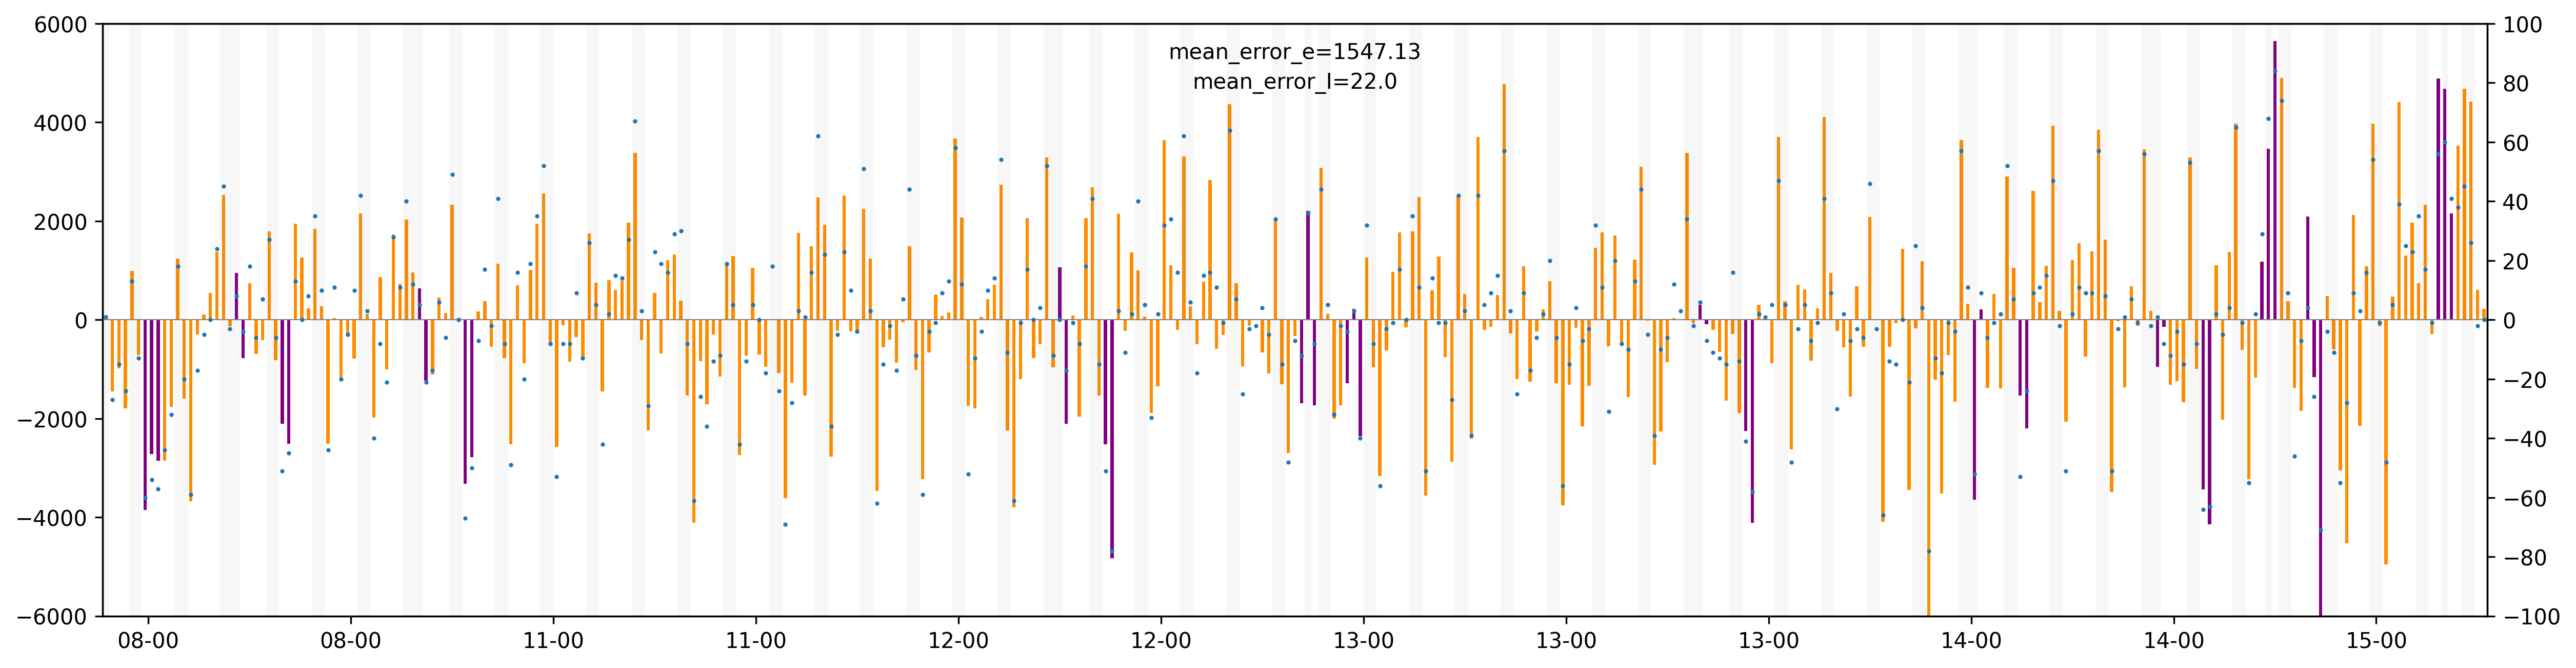

In [ ]:
ta=datetime(2019,1,1,0,0)
td=datetime(2020,1,1,0,0)

ev_gt=get_gt_ev(ta,td)
ev_gt_1week=get_gt_ev(ta-timedelta(days=8),td-timedelta(days=8))

EV_pred_convert=convert_table(ta-timedelta(days=8),td-timedelta(days=8),ev_gt_1week,24)
EV_gt_convert=convert_table(ta,td,ev_gt,24)

plot_ev_gt_pred(
    EV_pred_convert,
    EV_gt_convert,
    None,None,
    major_interval=24*31,
    minor_interval=24*31,
    y_limit_l=[-6000,6000],
    y_limit_r=[-100,100],
    display_error=True,
    bar_width=0.5
)

In [ ]:
def get_date_attr(t):
    us_holidays = holidays.US()
    if t in us_holidays or t.weekday()>=5:
        return "holiday"
    else:
        return "workday"

In [ ]:
a=get_date_attr(datetime(2019, 5, 27, 0, 0))

In [ ]:
import numpy as np
alpha=0.1
K=96
last_weights = np.exp(- alpha*(np.arange(K)+1))

In [ ]:
last_weights

array([9.04837418e-01, 8.18730753e-01, 7.40818221e-01, 6.70320046e-01,
       6.06530660e-01, 5.48811636e-01, 4.96585304e-01, 4.49328964e-01,
       4.06569660e-01, 3.67879441e-01, 3.32871084e-01, 3.01194212e-01,
       2.72531793e-01, 2.46596964e-01, 2.23130160e-01, 2.01896518e-01,
       1.82683524e-01, 1.65298888e-01, 1.49568619e-01, 1.35335283e-01,
       1.22456428e-01, 1.10803158e-01, 1.00258844e-01, 9.07179533e-02,
       8.20849986e-02, 7.42735782e-02, 6.72055127e-02, 6.08100626e-02,
       5.50232201e-02, 4.97870684e-02, 4.50492024e-02, 4.07622040e-02,
       3.68831674e-02, 3.33732700e-02, 3.01973834e-02, 2.73237224e-02,
       2.47235265e-02, 2.23707719e-02, 2.02419114e-02, 1.83156389e-02,
       1.65726754e-02, 1.49955768e-02, 1.35685590e-02, 1.22773399e-02,
       1.11089965e-02, 1.00518357e-02, 9.09527710e-03, 8.22974705e-03,
       7.44658307e-03, 6.73794700e-03, 6.09674657e-03, 5.51656442e-03,
       4.99159391e-03, 4.51658094e-03, 4.08677144e-03, 3.69786372e-03,
      